In [1]:
import numpy as np
import scipy.linalg as sp
import torch as th

import os, pdb, sys, json, glob, tqdm
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from itertools import product

sns.set_style('whitegrid')

sns.set_context('notebook')

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 200

%load_ext autoreload
%autoreload 2

dev = 'cuda'

In [2]:
from utils import *
from embed import *

### Avg by error

In [41]:
loc = 'results/models/new'
d = load_d(loc, cond={'bs':200, 'aug':True, 'wd':0.0, 'bn':True}, avg_err=True, numpy=True, probs=False)
d_ = drop_untrained(d, key='err', th=0.01, verbose=False).reset_index()
del d

d_["favg"] = pd.cut(d_["favg"], np.arange(0, 3, 0.1), include_lowest=True).astype(str)
groupby = ['m', 'opt', 'favg']
bdist = lambda x1, x2: -th.log(th.bmm(th.sqrt(x1), th.sqrt(x2).transpose(1, 2)))
avg, dists = avg_model(d_, groupby=groupby, probs=False, get_err=False,
                       compute_distance=True, distf=bdist, dev='cuda')

Index(['seed', 'm', 'opt', 'lr', 'wd', 'bn', 'aug', 'bs', 't', 'yh', 'f', 'e',
       'yvh', 'fv', 'ev', 'err', 'verr', 'favg', 'vfavg'],
      dtype='object') 1980


<AxesSubplot:xlabel='favg', ylabel='0'>

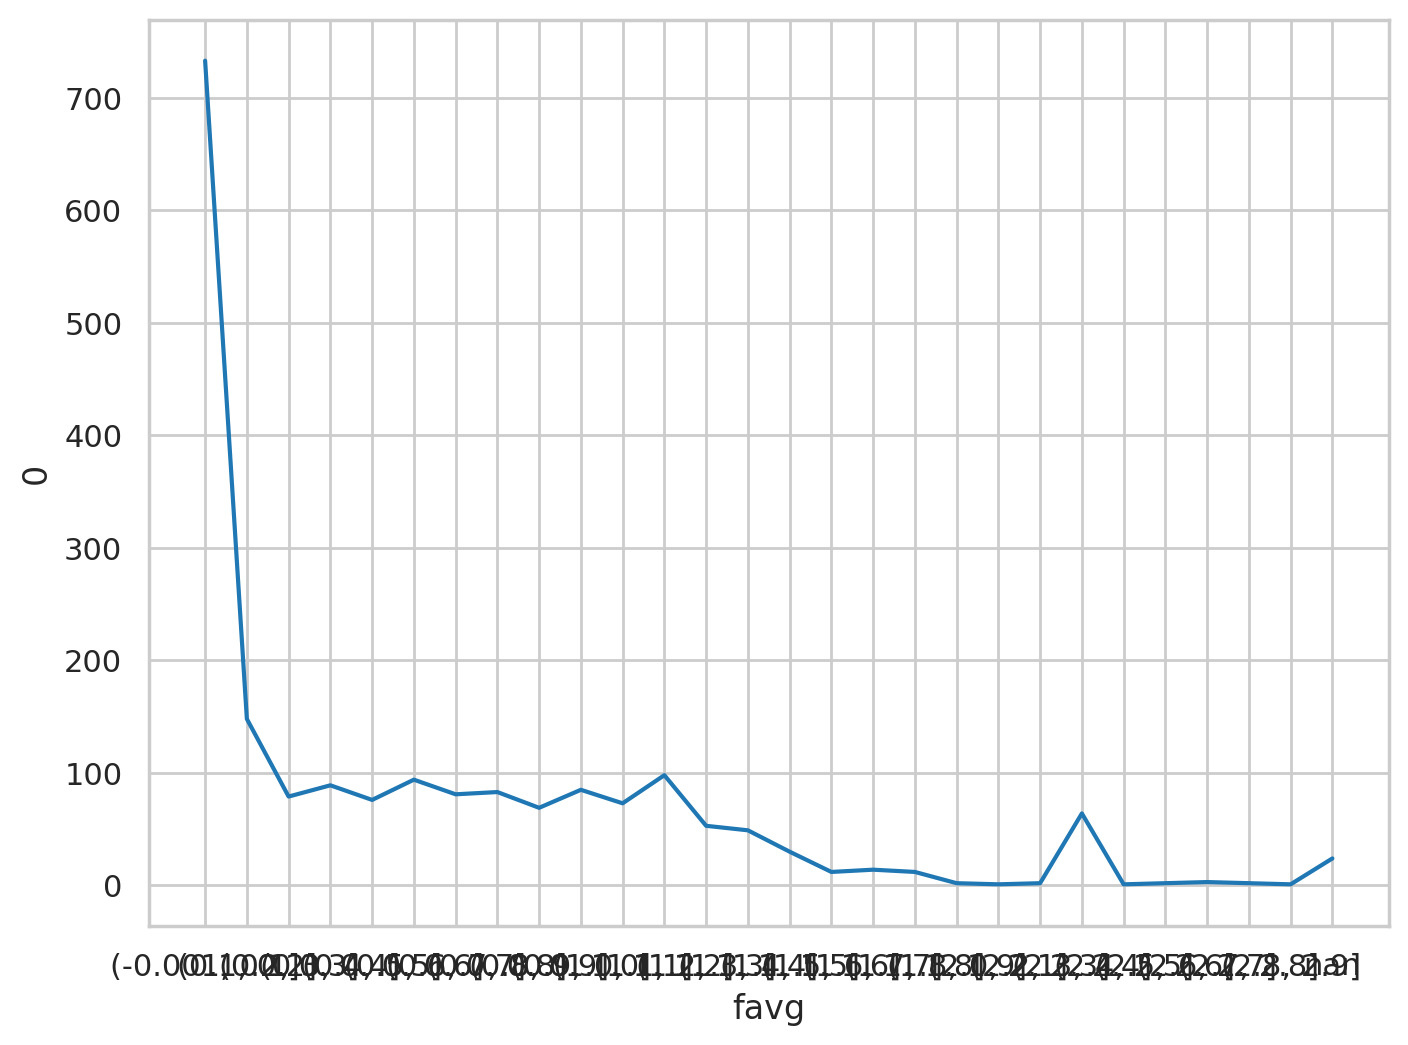

In [42]:
temp = pd.DataFrame(d_.groupby('favg').size())
sns.lineplot(data=temp, x='favg', y=0)

Text(0.5, 1.0, "opt == 'sgd'")

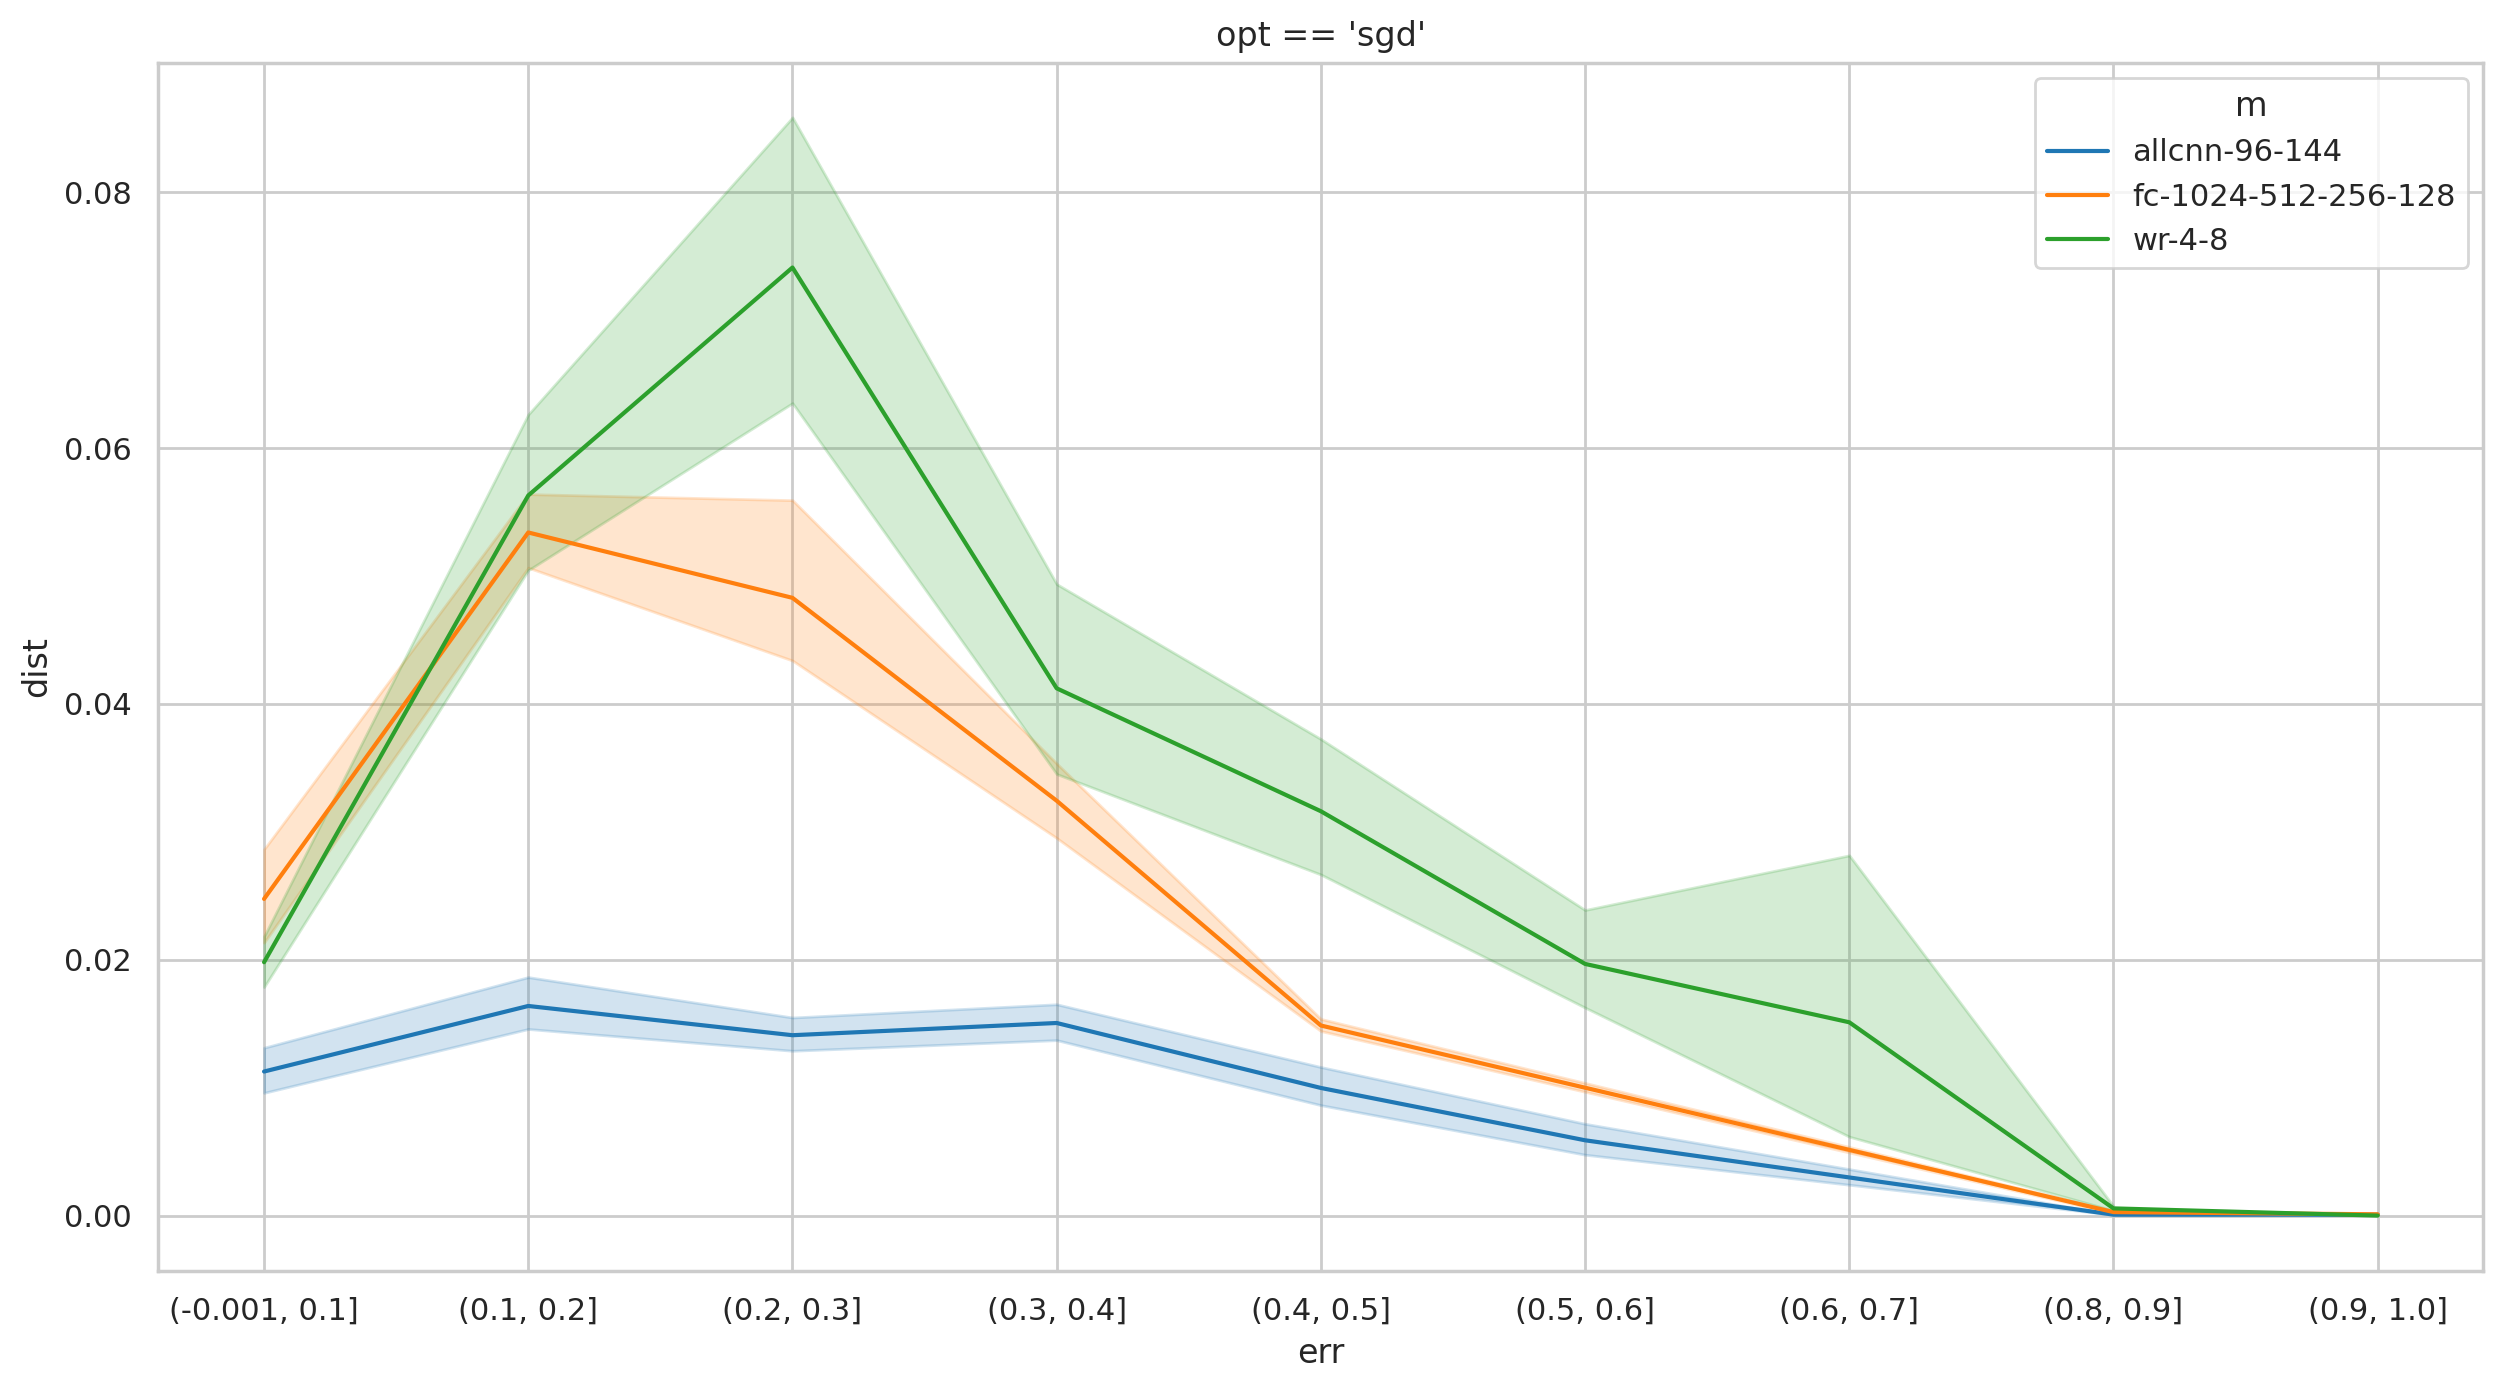

In [92]:
opt = opts[2]
plt.figure(figsize = (15,8))
ax = sns.lineplot(data=dists.iloc[get_idx(dists, f"key == 'yh' & opt == {opt}")].sort_values(by='err'),
             x='err', y='dist', hue='m')
ax.set_title(f"opt == {opt}")

Text(0.5, 1.0, "m == 'fc-1024-512-256-128'")

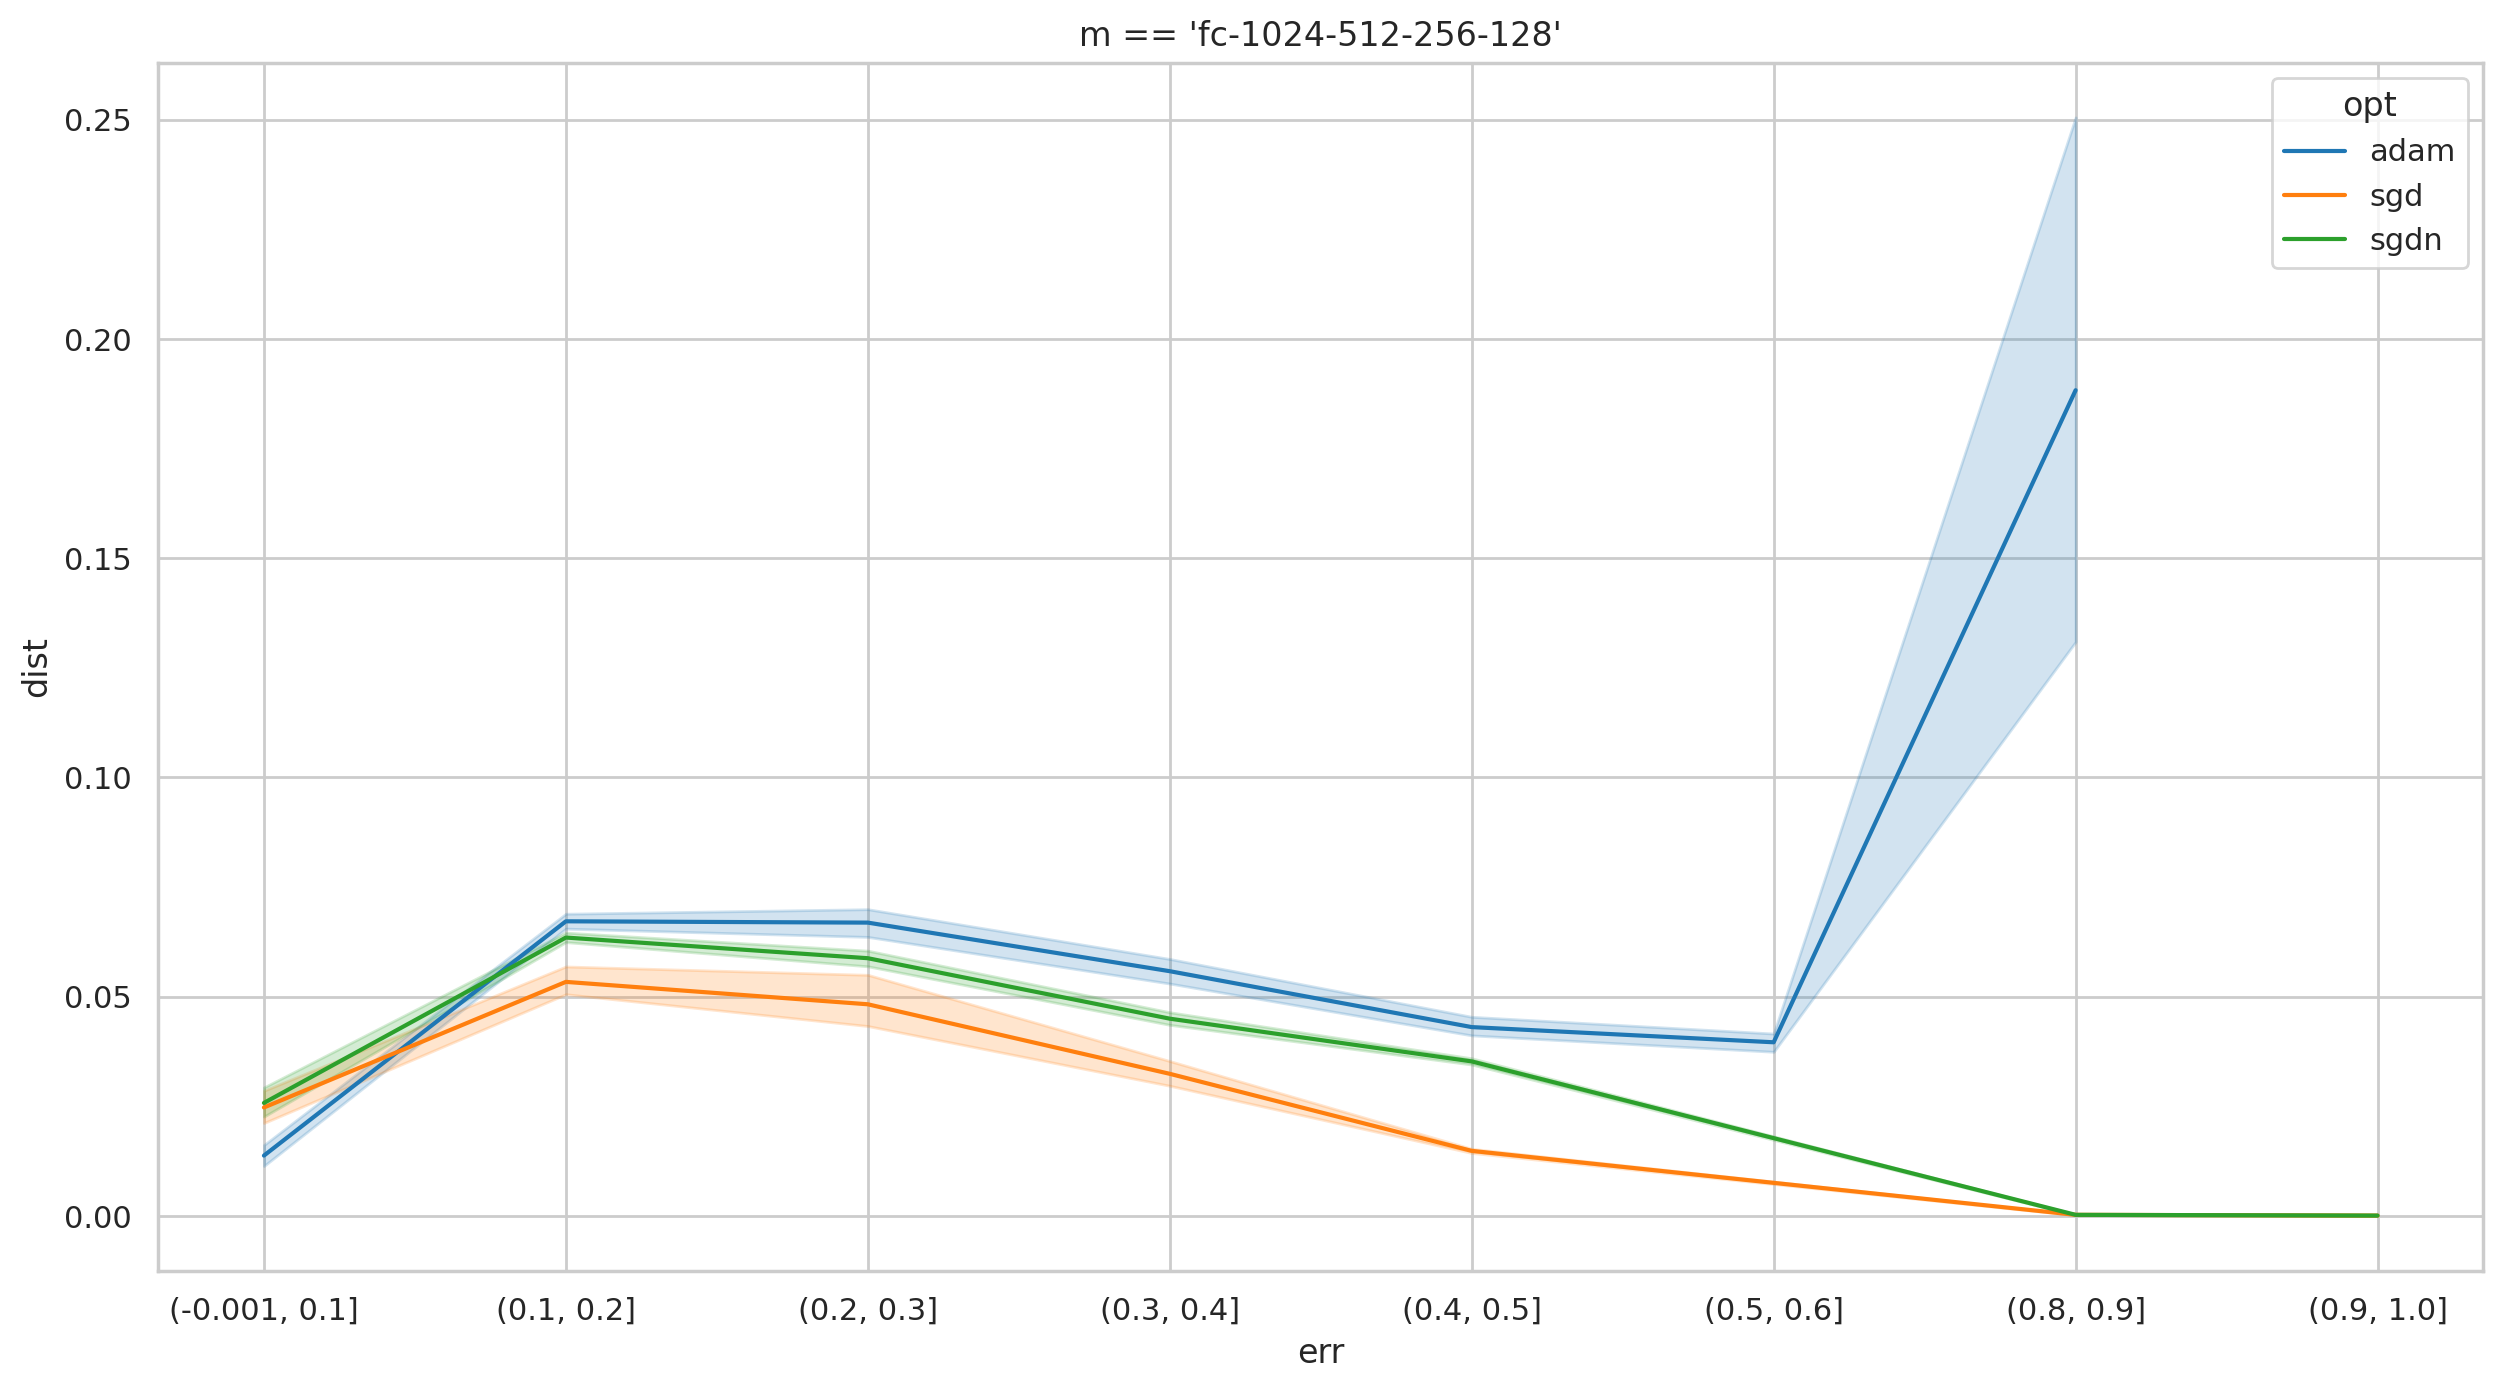

In [88]:
m = models[2]
plt.figure(figsize = (15,8))
ax=sns.lineplot(data=dists.iloc[get_idx(dists, f"key == 'yh' & m == {m}")].sort_values(by='err'),
             x='err', y='dist', hue='opt')
ax.set_title(f"m == {m}")

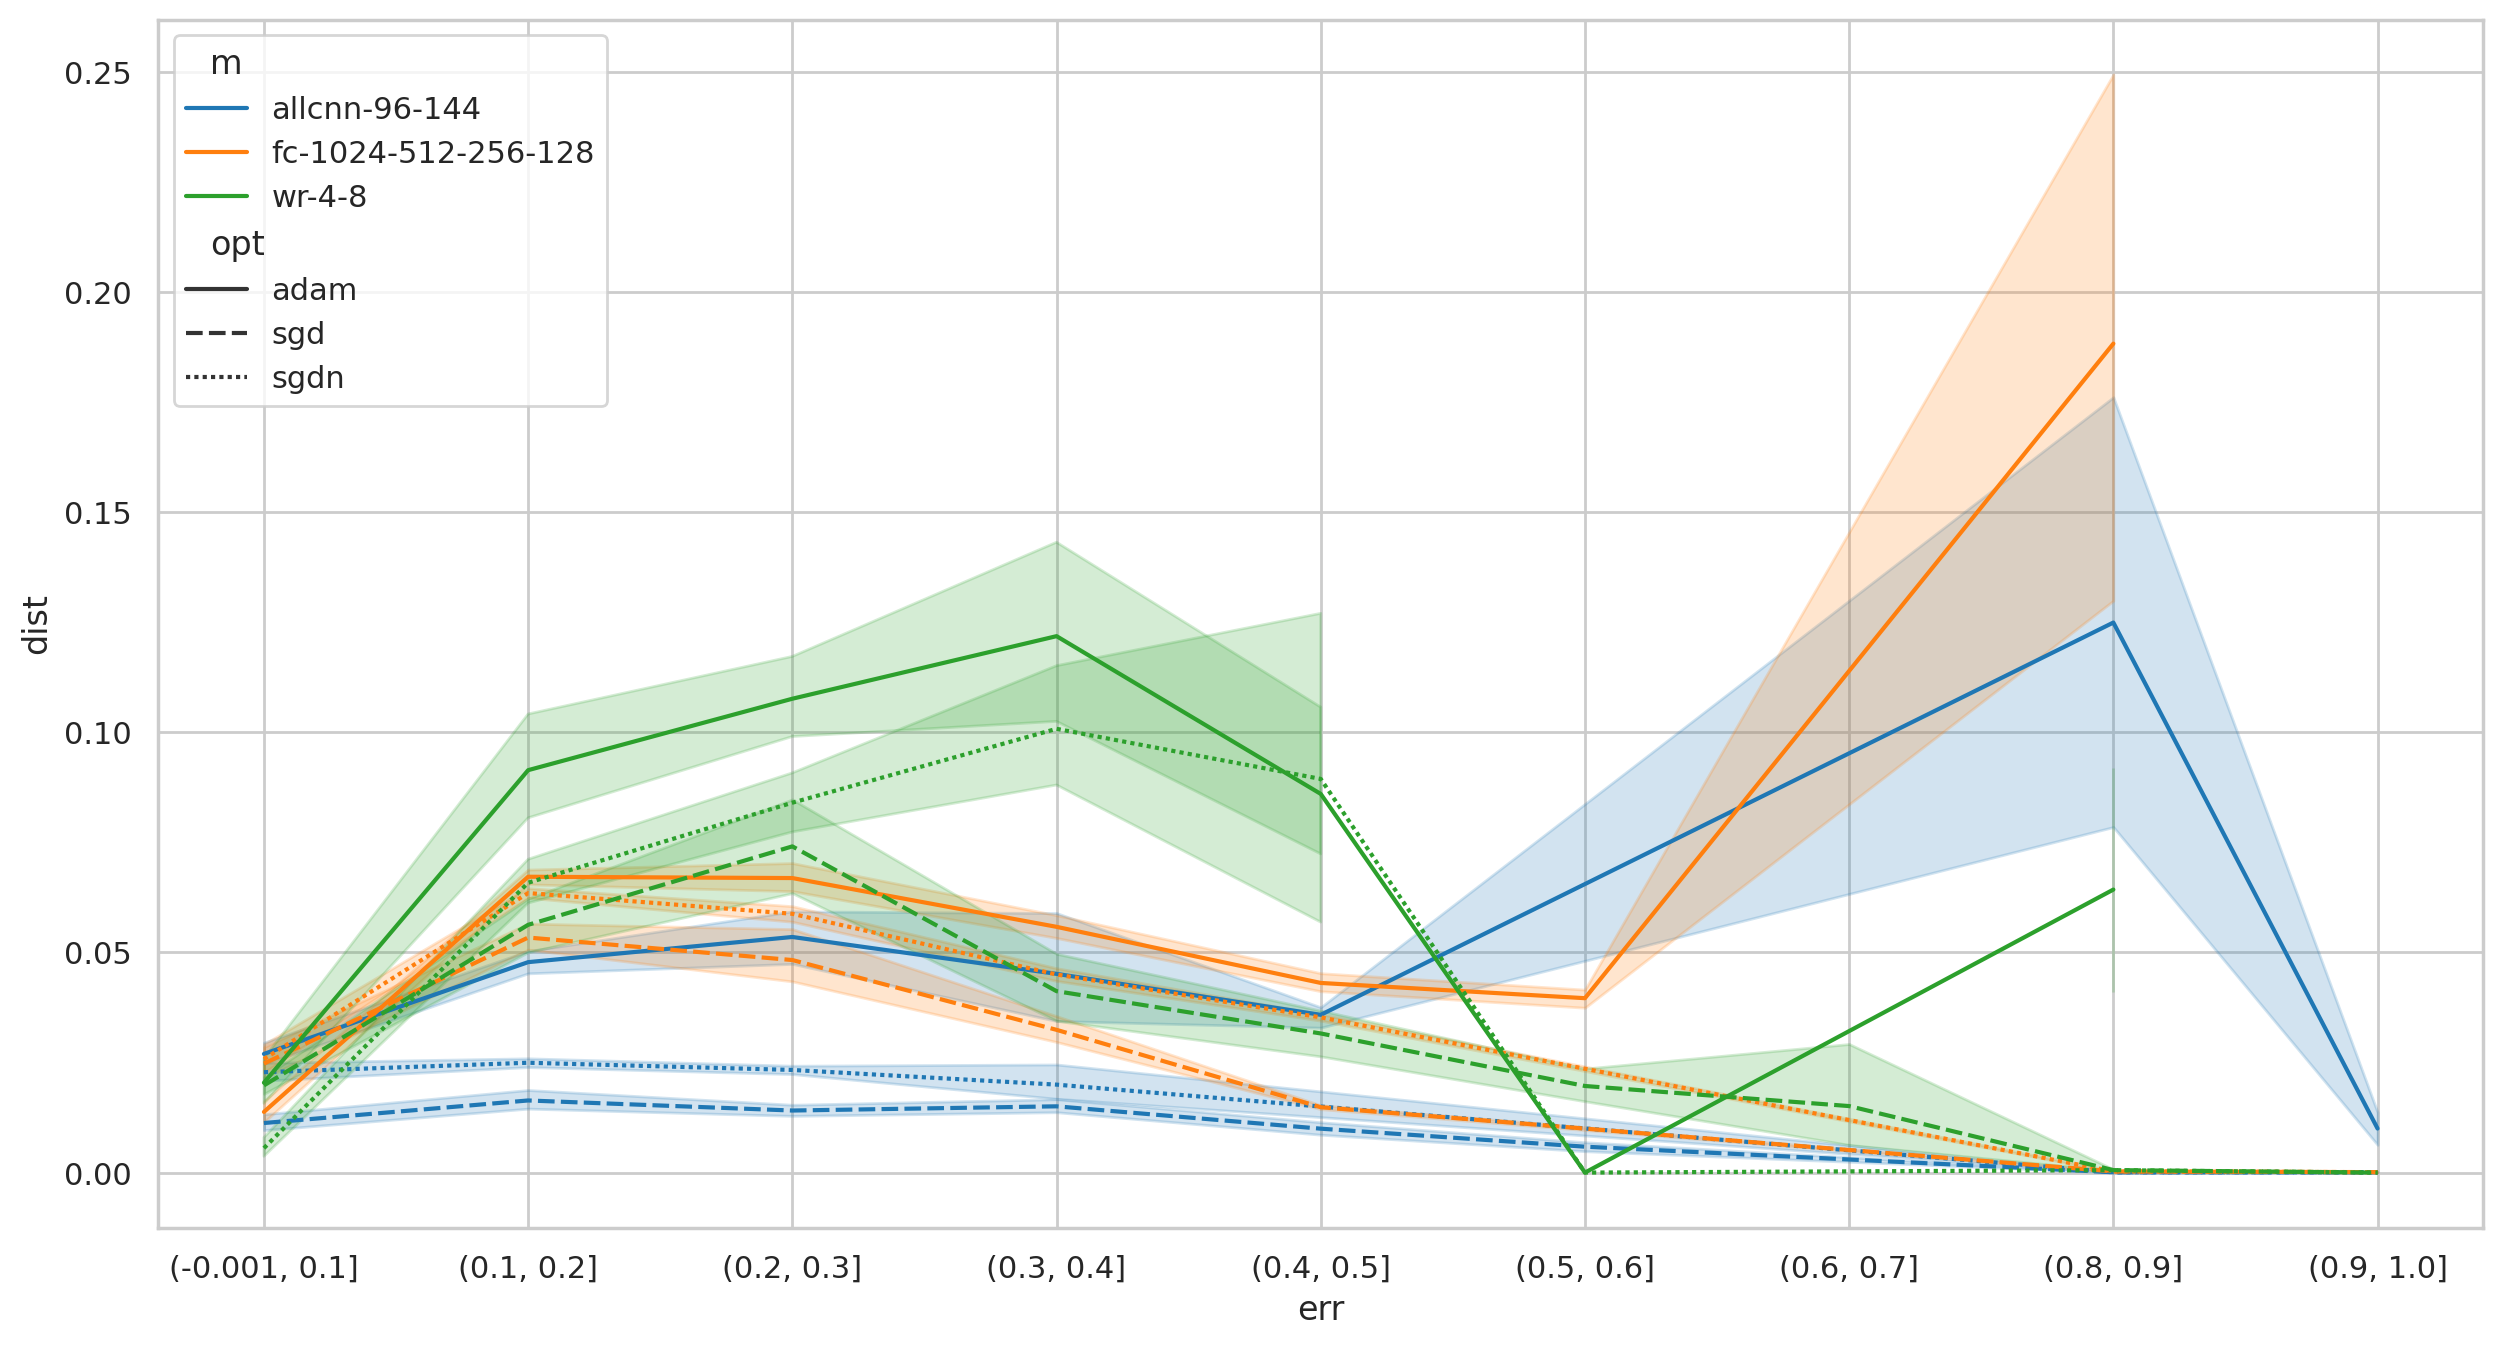

In [89]:
plt.figure(figsize = (15,8))
ax = sns.lineplot(data=dists.iloc[get_idx(dists, f"key == 'yh'")].sort_values(by='err'),
             x='err', y='dist', hue='m', style='opt')

## Distance from averaged model
Model 0 is saved after first optimization step, which might explain the larger distance of adam at t=0

In [5]:
loc = 'results/models/new'
d = load_d(loc, cond={'bs':200, 'aug':True, 'wd':0.0, 'bn':True}, avg_err=True, numpy=True, probs=False)
d_ = drop_untrained(d, key='err', th=0.01, verbose=False).reset_index()
del d

Index(['seed', 'm', 'opt', 'lr', 'wd', 'bn', 'aug', 'bs', 't', 'yh', 'f', 'e',
       'yvh', 'fv', 'ev', 'err', 'verr', 'favg', 'vfavg'],
      dtype='object') 1800


In [6]:
bdist = lambda x1, x2: -th.log(th.bmm(th.sqrt(x1), th.sqrt(x2).transpose(1, 2)))
avg, dists = avg_model(d_, groupby=['m', 'opt', 't'], probs=False, get_err=False,
                       compute_distance=True, distf=bdist, dev='cuda')

<AxesSubplot:xlabel='t', ylabel='dist'>

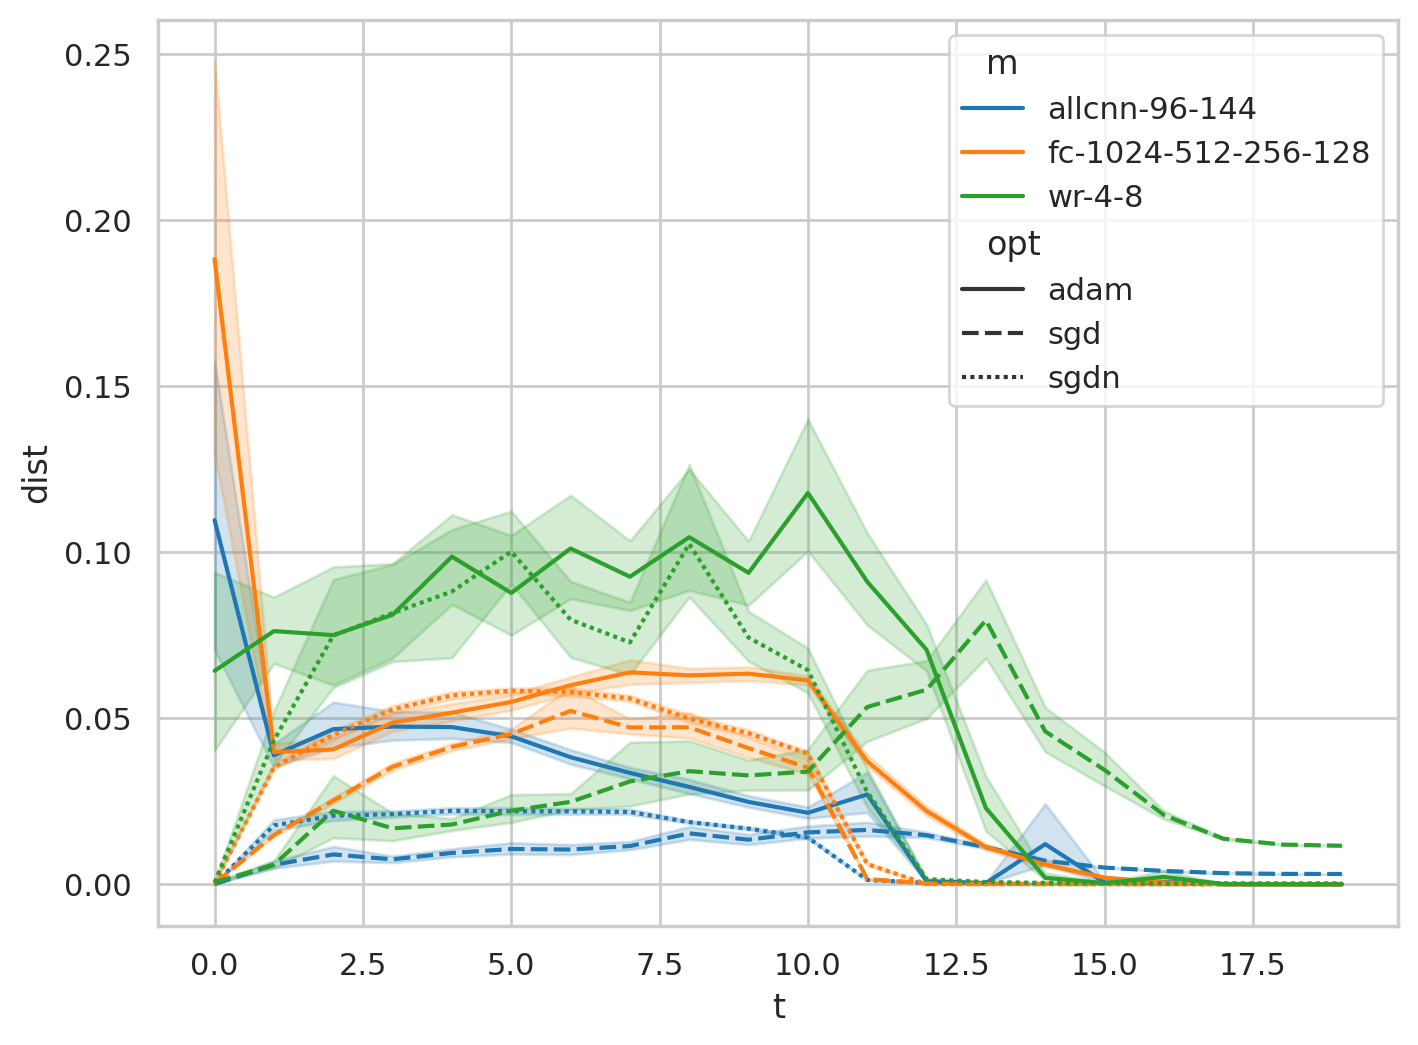

In [74]:
sns.lineplot(data=dists.iloc[get_idx(dists, f"key == 'yh'")],
             x='t', y='dist', hue='m', style='opt')

in the sgd plot, fc and wr seem to have different peaks, but see the avg by error plot, that's appearing at similar error level

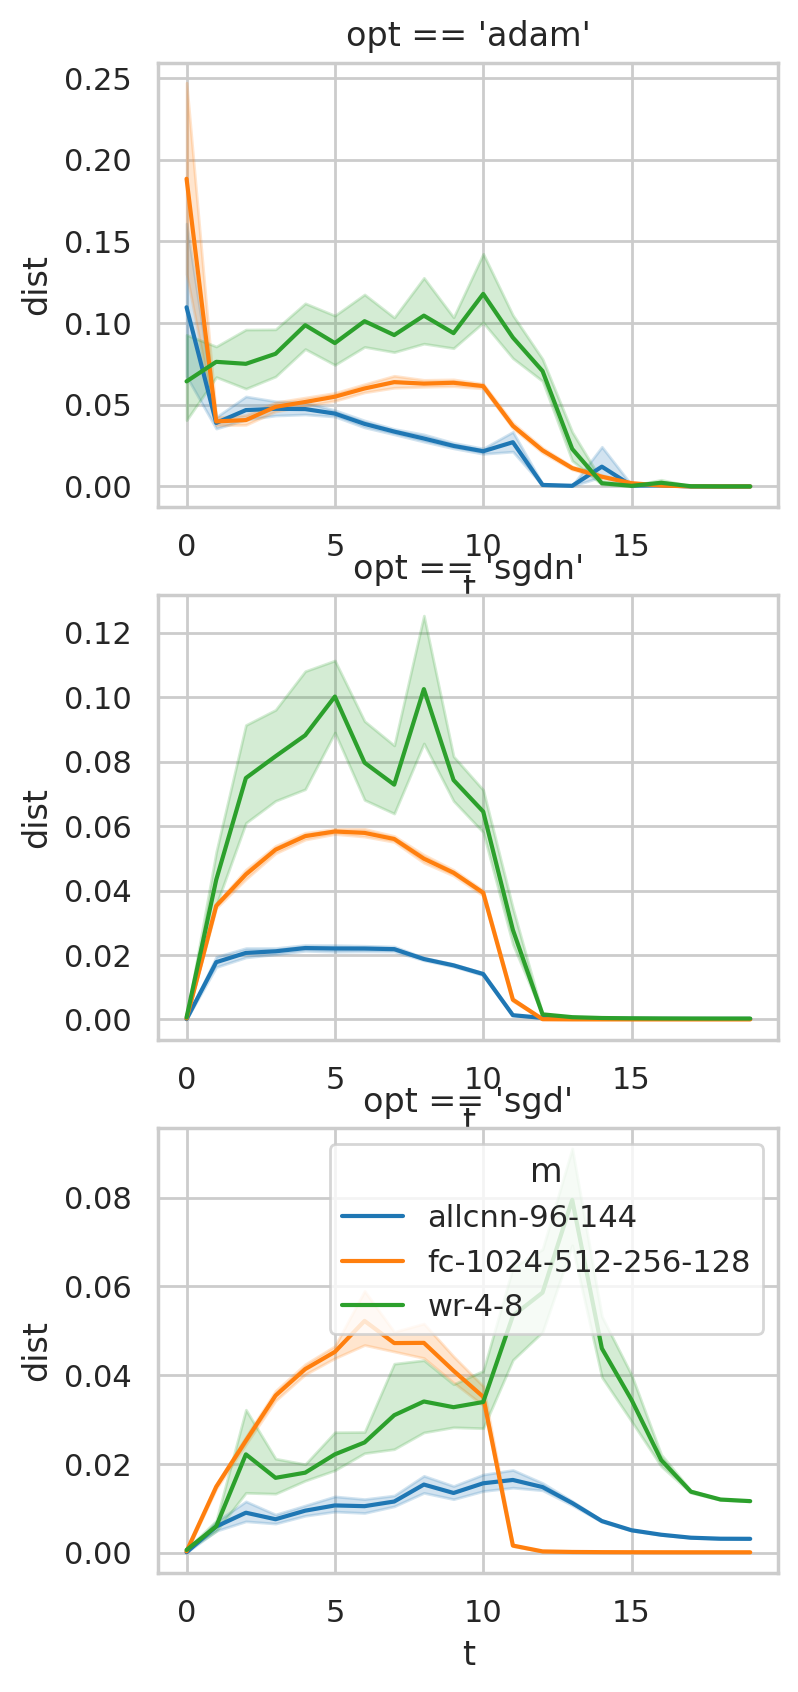

In [66]:
fig, axes = plt.subplots(3,1, figsize=(4, 10))
for (i,opt) in enumerate(opts):
    use_legend = True if i == 2 else False
    sns.lineplot(data=dists.iloc[get_idx(dists, f"key == 'yh' & opt == {opt}")],
             x='t', y='dist', hue='m', ax=axes[i], legend=use_legend)
    axes[i].set_title(f"opt == {opt}")

<AxesSubplot:xlabel='t', ylabel='err'>

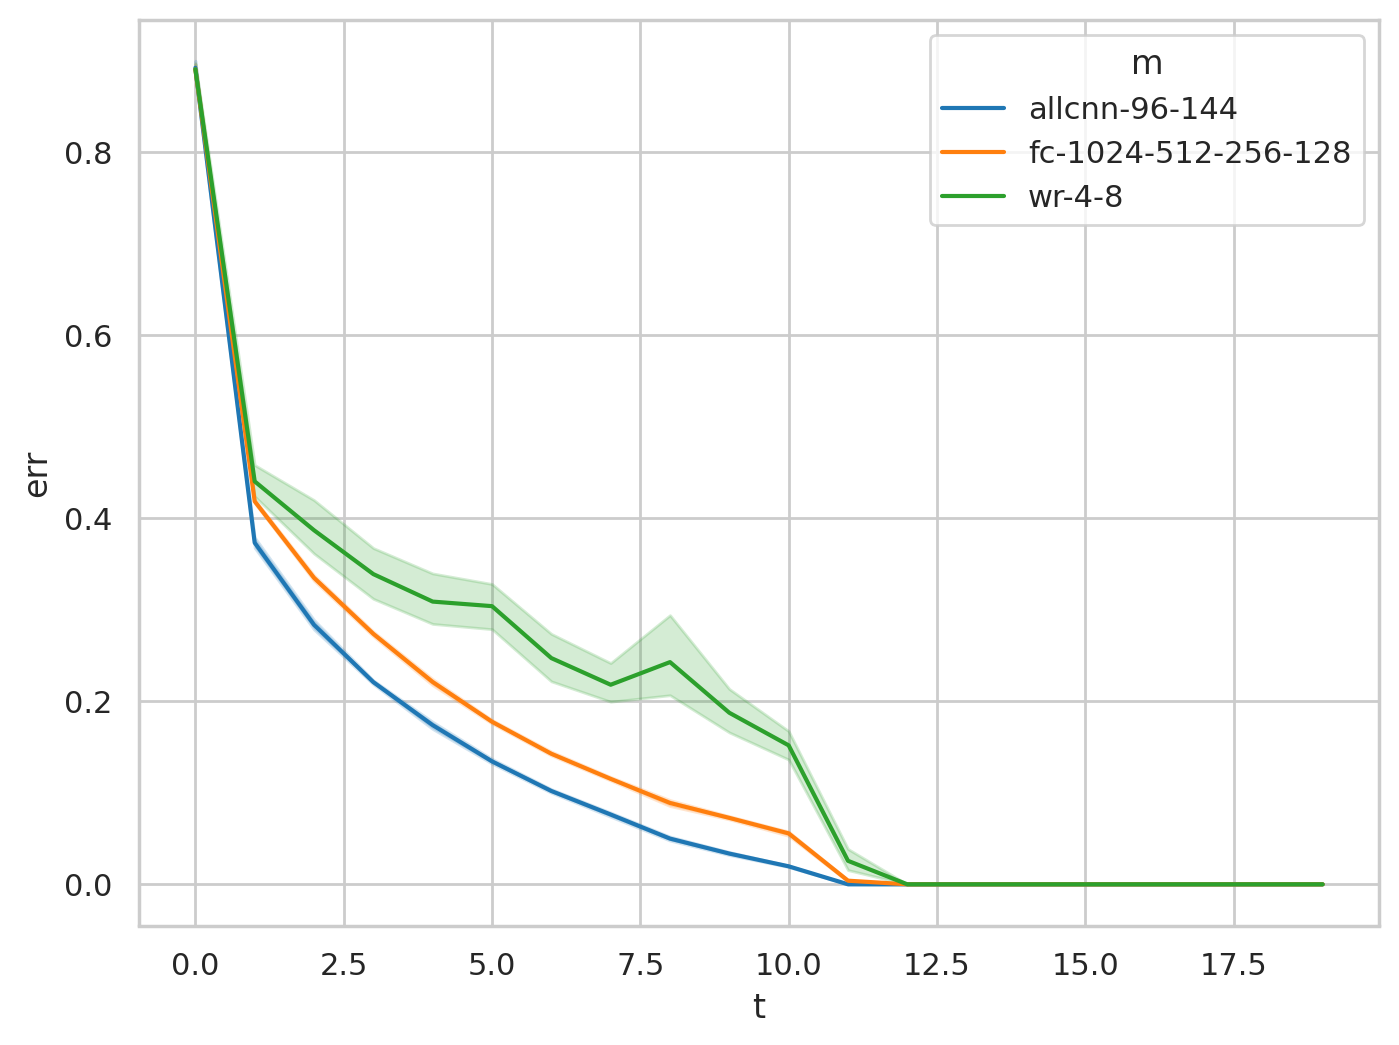

In [65]:
sns.lineplot(data=d_.iloc[get_idx(d_, f"opt == 'sgdn'")],
             x='t', y='err', hue='m')

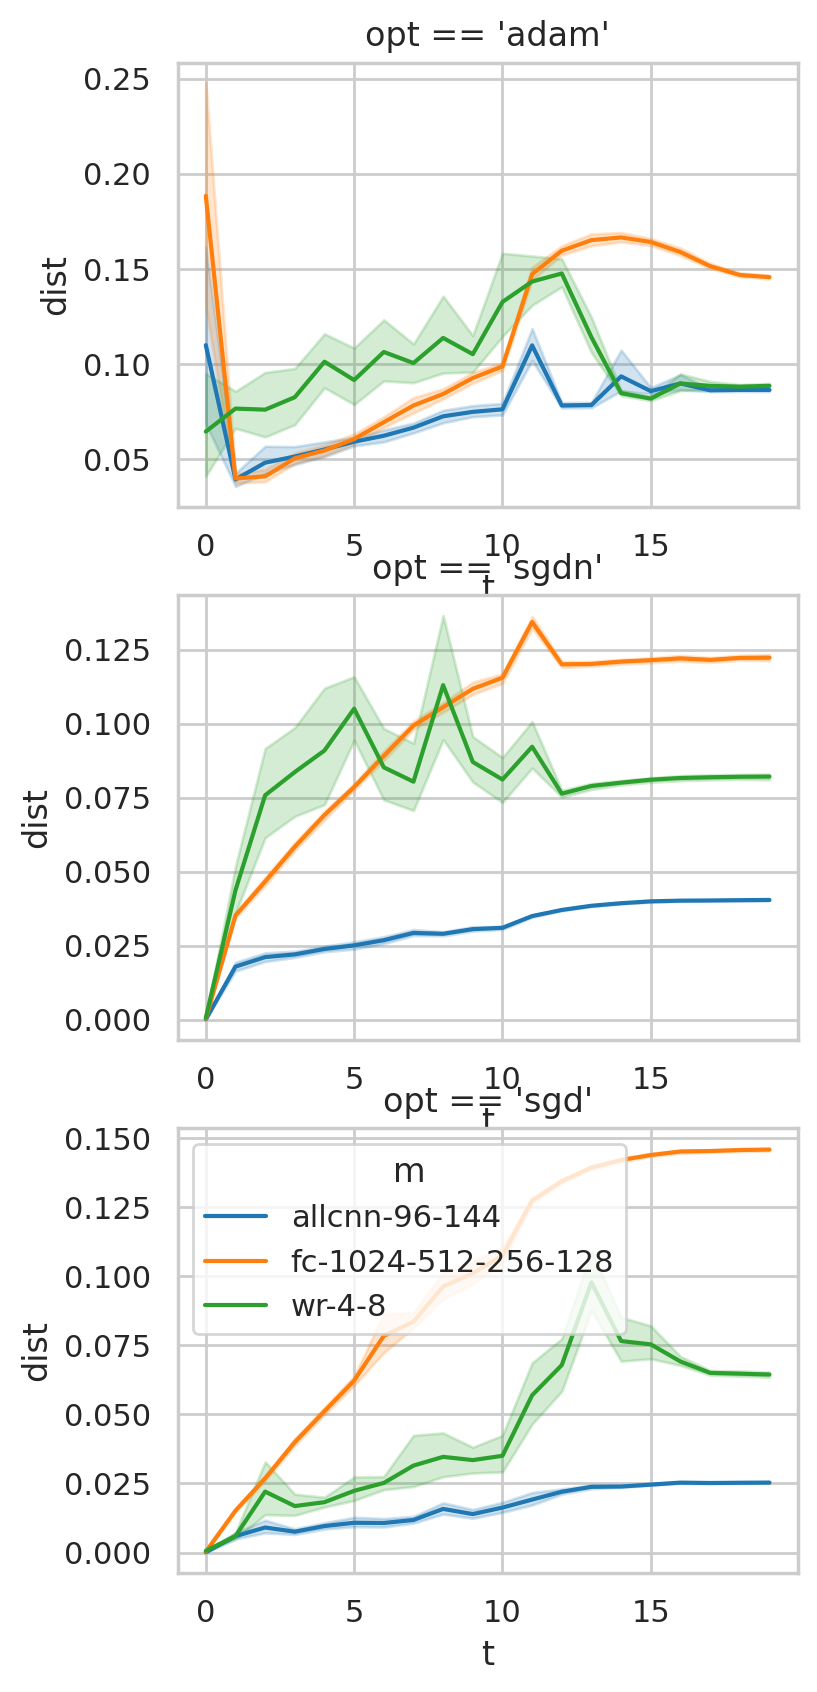

In [67]:
fig, axes = plt.subplots(3,1, figsize=(4, 10))
for (i,opt) in enumerate(opts):
    use_legend = True if i == 2 else False
    sns.lineplot(data=dists.iloc[get_idx(dists, f"key == 'yvh' & opt == {opt}")],
             x='t', y='dist', hue='m', ax=axes[i], legend=use_legend)
    axes[i].set_title(f"opt == {opt}")

<AxesSubplot:xlabel='t', ylabel='verr'>

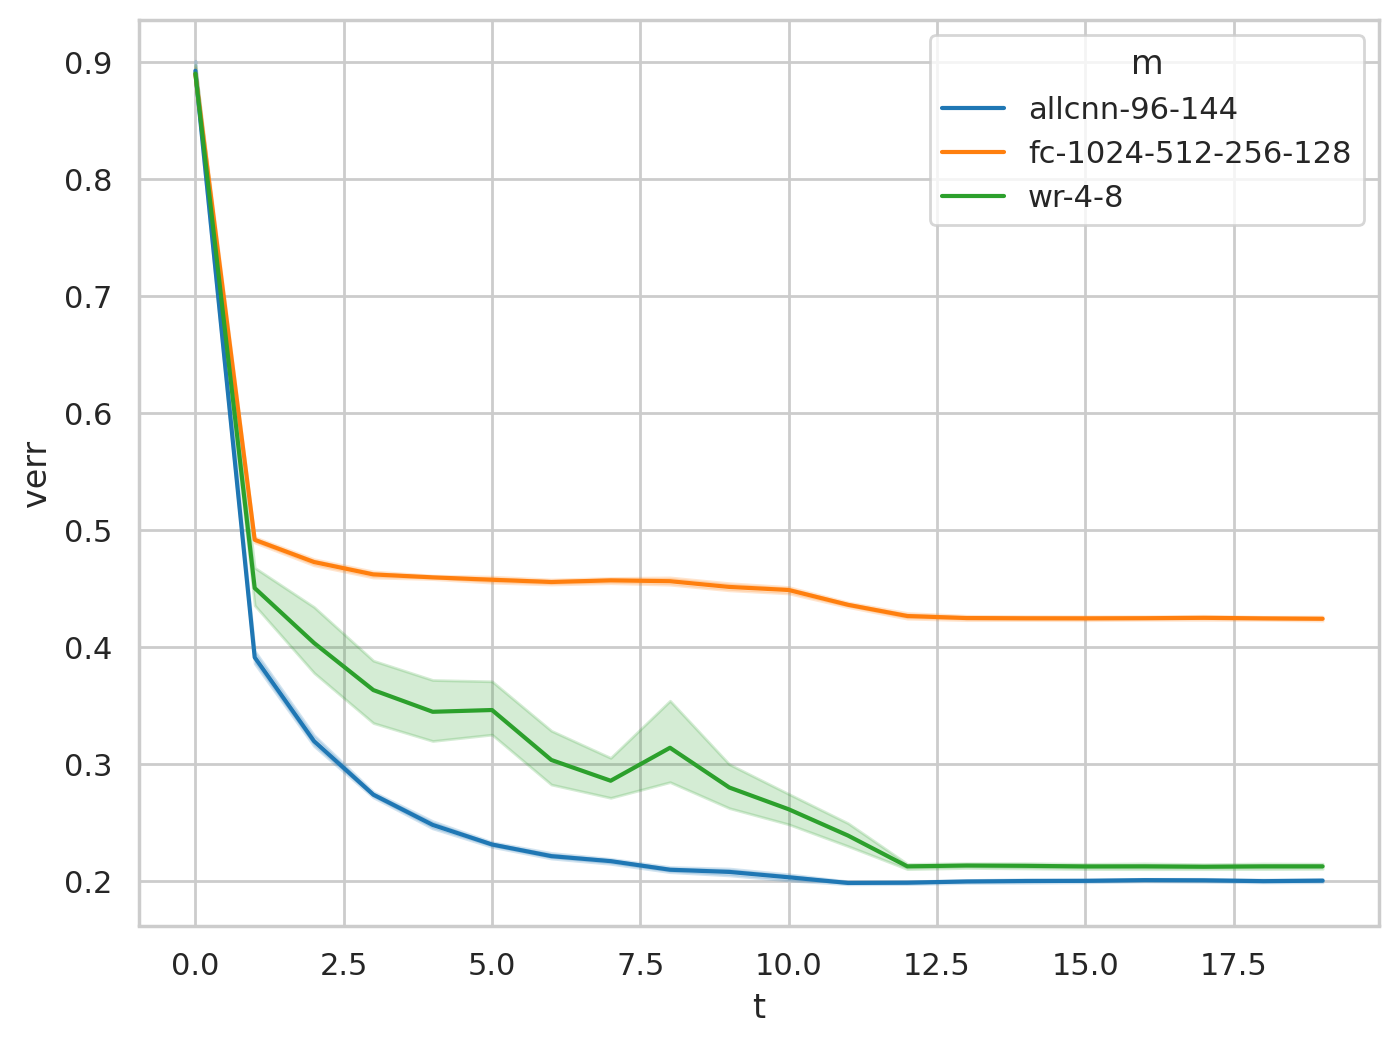

In [71]:
sns.lineplot(data=d_.iloc[get_idx(d_, f"opt == 'sgdn'")],
             x='t', y='verr', hue='m')

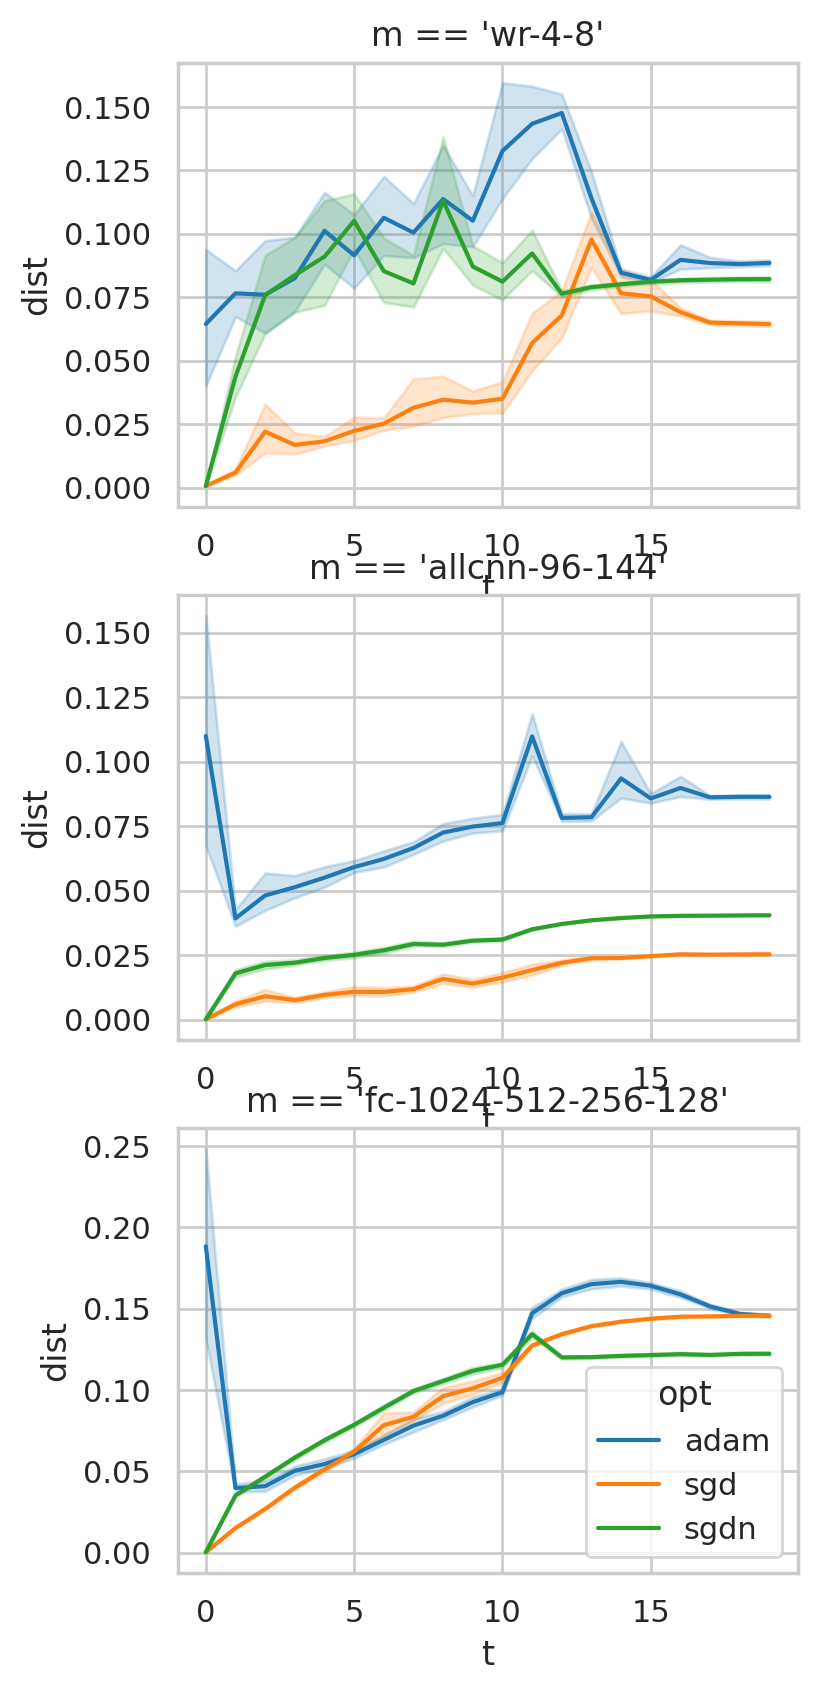

In [73]:
fig, axes = plt.subplots(3,1, figsize=(4, 10))
for (i,m) in enumerate(models):
    use_legend = True if i == 2 else False
    sns.lineplot(data=dists.iloc[get_idx(dists, f"key == 'yvh' & m == {m}")],
             x='t', y='dist', hue='opt', ax=axes[i], legend=use_legend)
    axes[i].set_title(f"m == {m}")

### disagreement vs ensemble

In [4]:
loc = 'results/models/new'
d = load_d(loc, cond={'bs':200, 'aug':True, 'wd':0.0, 'bn':True}, avg_err=True, numpy=True, probs=False)
d_ = drop_untrained(d, key='err', th=0.01, verbose=False).reset_index()
del d

Index(['seed', 'm', 'opt', 'lr', 'wd', 'bn', 'aug', 'bs', 't', 'yh', 'f', 'e',
       'yvh', 'fv', 'ev', 'err', 'verr', 'favg', 'vfavg'],
      dtype='object') 1960


In [5]:
avg = avg_model(d_, groupby=['m', 'opt', 't'], probs=False, get_err=True, compute_distance=False, dev='cuda')

In [9]:
data = []
labels = get_data(dev='cpu')['yv'].numpy()
i=0
for m in models:
    for opt in opts:
        model = f"m=={m} & opt=={opt} & t==19"
        
        ens_preds = np.stack(avg.iloc[get_idx(avg, model)]['yvh'])
        ens_preds = np.argmax(ens_preds.reshape(ens_preds.shape[0], -1, 10), axis=-1)
        
        m_preds = np.stack(d_.iloc[get_idx(d_, model)]['yvh'])
        m_preds = np.argmax(m_preds.reshape(m_preds.shape[0], -1, 10), axis=-1)
        x = np.stack([m_preds[:, i:i+1] == m_preds[:, i:i+1].T for i in range(10000)]).mean(0)
        x = x[np.triu_indices(10, 1)]
        data.append(dict(err=(ens_preds == labels).mean(axis=1)[0], mode='ens', config=(i, m, opt)))
        for px in x:
            data.append(dict(err=px, mode='disagreement', config=(i, m, opt)))
        print(i, (m, opt))
        i += 1
        

0 ("'wr-4-8'", "'adam'")
1 ("'wr-4-8'", "'sgdn'")
2 ("'wr-4-8'", "'sgd'")
3 ("'allcnn-96-144'", "'adam'")
4 ("'allcnn-96-144'", "'sgdn'")
5 ("'allcnn-96-144'", "'sgd'")
6 ("'fc-1024-512-256-128'", "'adam'")
7 ("'fc-1024-512-256-128'", "'sgdn'")
8 ("'fc-1024-512-256-128'", "'sgd'")


In [10]:
df = pd.DataFrame(data)

[Text(0, 0, '(0, "\'wr-4-8\'", "\'adam\'")'),
 Text(1, 0, '(1, "\'wr-4-8\'", "\'sgdn\'")'),
 Text(2, 0, '(2, "\'wr-4-8\'", "\'sgd\'")'),
 Text(3, 0, '(3, "\'allcnn-96-144\'", "\'adam\'")'),
 Text(4, 0, '(4, "\'allcnn-96-144\'", "\'sgdn\'")'),
 Text(5, 0, '(5, "\'allcnn-96-144\'", "\'sgd\'")'),
 Text(6, 0, '(6, "\'fc-1024-512-256-128\'", "\'adam\'")'),
 Text(7, 0, '(7, "\'fc-1024-512-256-128\'", "\'sgdn\'")'),
 Text(8, 0, '(8, "\'fc-1024-512-256-128\'", "\'sgd\'")')]

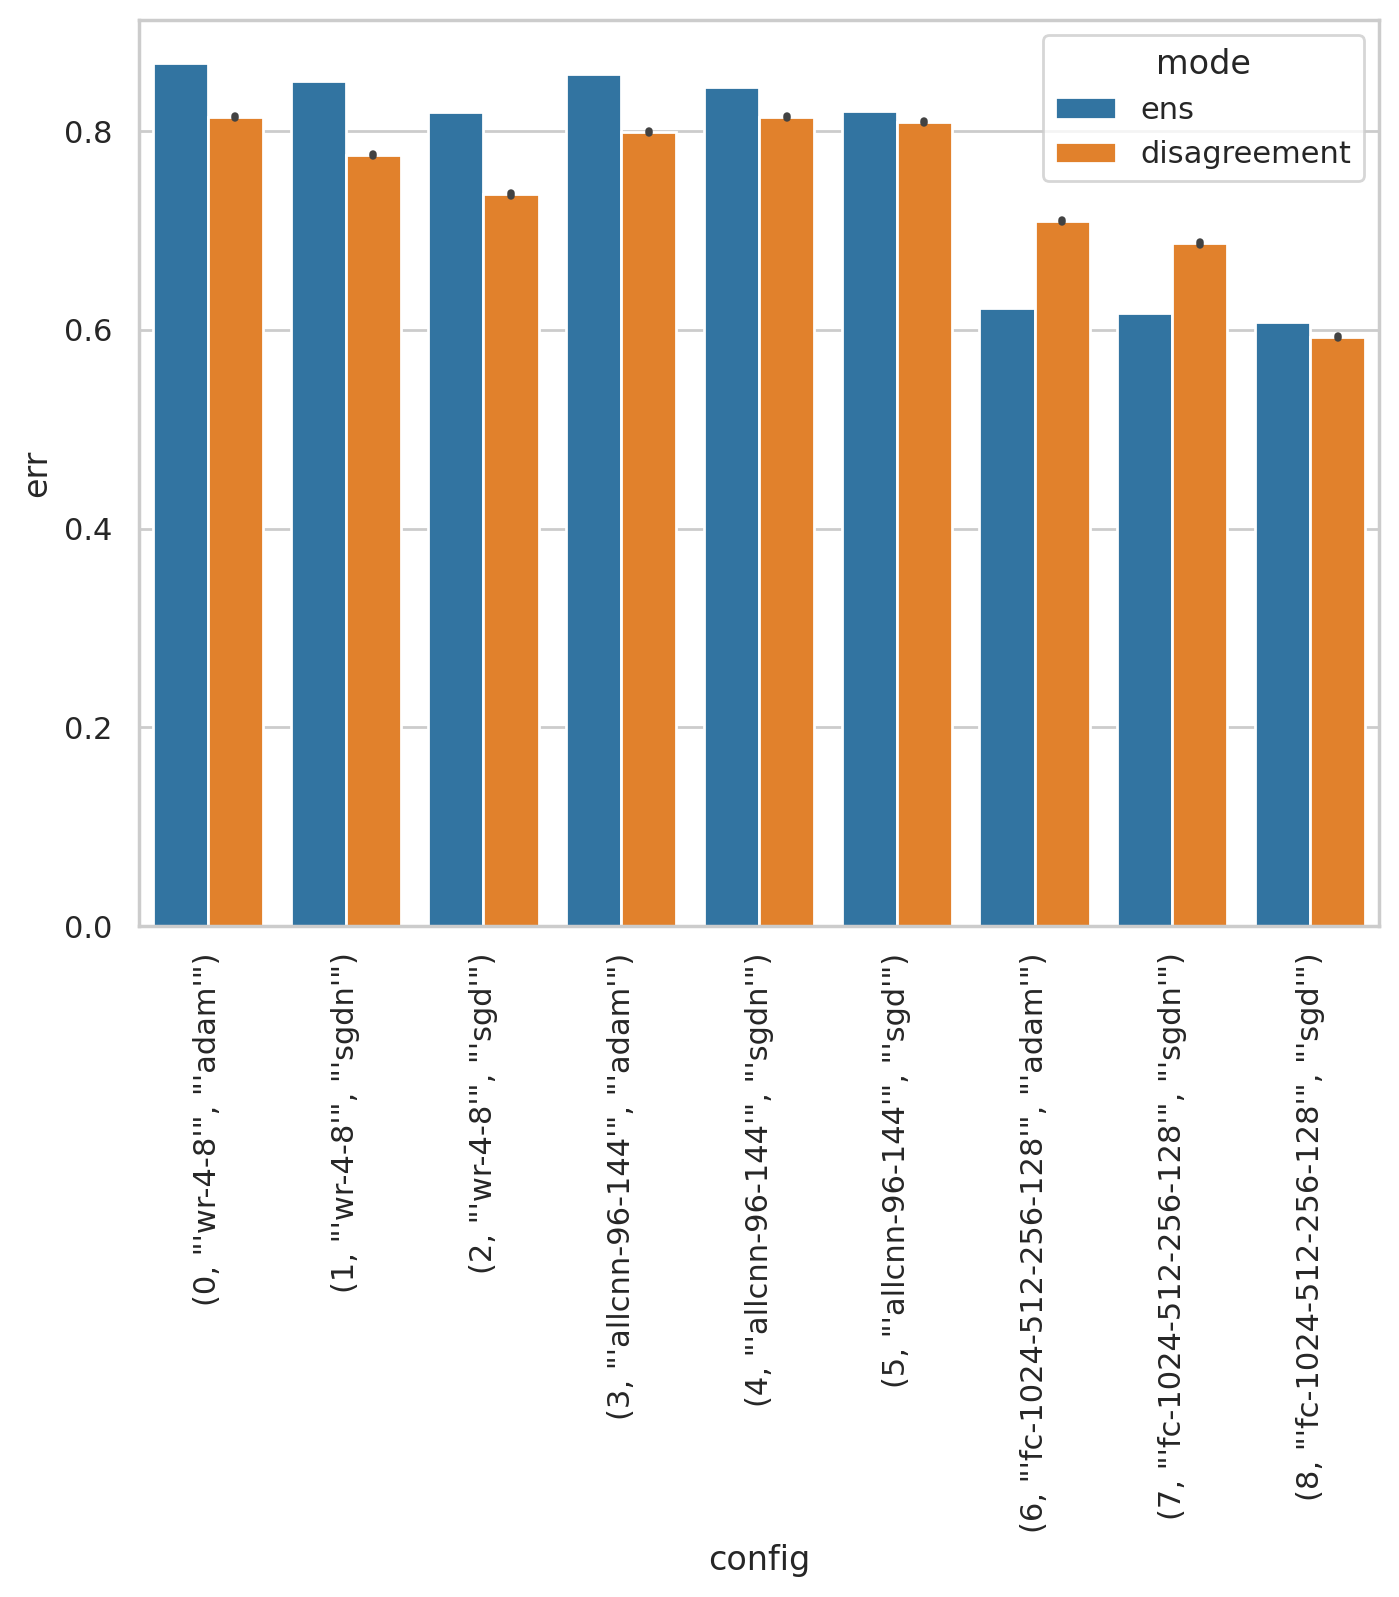

In [14]:
ax=sns.barplot(data=df,  x='config', y='err', hue='mode')

ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

## Path Distance

In [3]:
from utils import models, opts
loc = 'results/models/new'
d = load_d(loc, cond={'bs':[200], 'aug':[True], 'wd':[0.0], 'bn':[True], 'm':models, 'opt':opts}, 
           drop_untrained=False, avg_err=True)

avg = avg_model(d_, groupby=['m', 'opt', 't'], probs=False, get_err=True, 
                       compute_distance=False, dev='cuda')

Index(['seed', 'm', 'opt', 'lr', 'wd', 'bn', 'aug', 'bs', 't', 'yh', 'f', 'e',
       'yvh', 'fv', 'ev', 'err', 'verr', 'favg', 'vfavg'],
      dtype='object') 1800


In [8]:
from itertools import product
dists = []
for k in ['yh', 'yvh']:

    # for m in product(models, opts):
    for o in opts:
        for m in models:
            avgm = np.stack(avg.iloc[get_idx(avg, f"m=={m} & opt=={o}")][k])
            x1 = th.Tensor(avgm.reshape([len(avgm), -1, 10])).transpose(0, 1).to(dev)
            for s in d_['seed'].unique():
                x2 = np.stack(d_.iloc[get_idx(d_, f"m=={m} & opt=={o} & seed=={s}")][k])
                
        #         print(yh.shape)
                x2 = x2.reshape(len(x2), -1, 10)
                x2 = th.Tensor(x2).transpose(0, 1).to(dev)
                dist = -th.log(th.bmm(th.sqrt(x1), th.sqrt(x2).transpose(1, 2))).mean(0)
                min_idx = 0
                for i in range(20):
                    m_ = th.min(dist[i, min_idx:], dim=0)
                    min_idx = min_idx + m_.indices.item()
                    dists.append(dict(dist=m_.values.item(), idx=min_idx, 
                                      m=m.strip("''"), opt=o.strip("''"), t=i, key=k))
        #             dists.append(dict(dist=dist[i, i].item(), idx=m_.indices.item(), m=m, opt=o, t=i))

Text(0.5, 1.0, 'distance to average model')

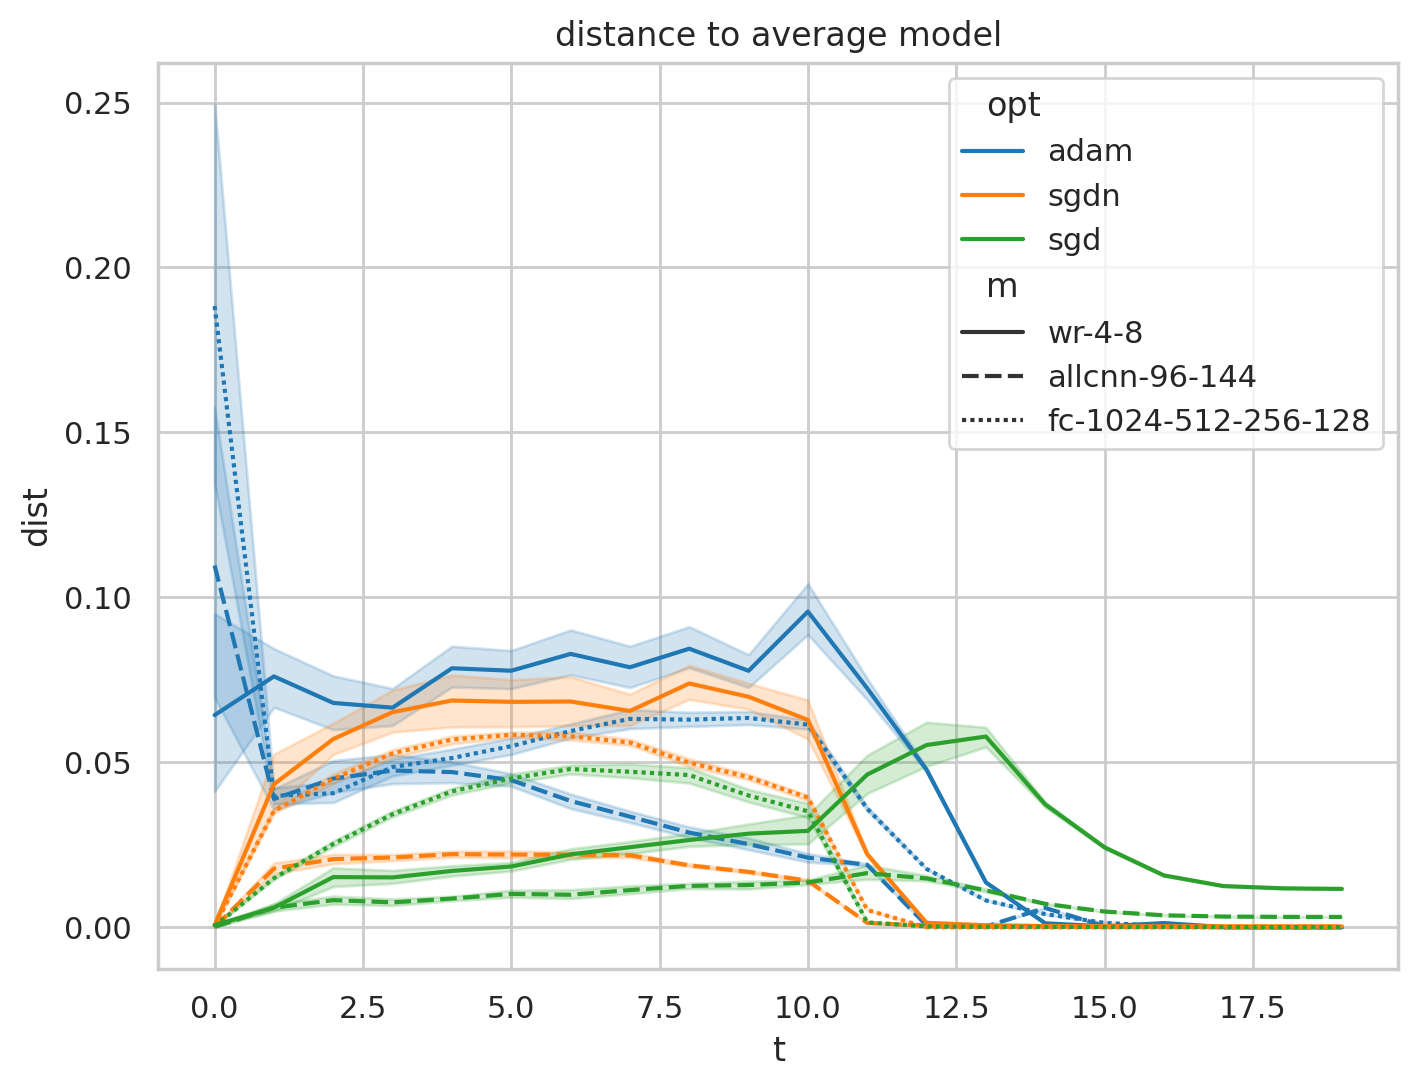

In [10]:
dists = pd.DataFrame(dists)
ax=sns.lineplot(data=dists[dists['key'] == 'yh'], x='t', y='dist', hue='opt', style='m')
ax.set_title('distance to average model')

In [21]:
from itertools import product
from scipy.interpolate import interpn


# N=100
# pts = np.linspace(0, T-1, N)
ts = ts.flatten()
pts = np.concatenate([np.arange(ts[i], ts[i+1], (ts[i+1]-ts[i]) // 5) for i in range(len(ts)-1)])
# pts = ts
N = len(pts)
ts = ts.reshape(1, -1)
dists = []
# for s in np.concatenate([np.arange(0.01, 0.1, 0.05), np.arange(0.1, 1, 0.2)]):
s = 0.1
for k in ['yh']:
    for o in opts:
        for m in models:
            avgm = np.stack(avg.iloc[get_idx(avg, f"m=='{m}' & opt=='{o}'")][k])
            x1 = interpn(ts, avgm, pts)
#             x1 = avgm
            x1 = th.Tensor(x1.reshape([len(x1), -1, 10])).transpose(0, 1).to(dev)
            for seed in d_['seed'].unique():
                x2 = np.stack(d_.iloc[get_idx(d_, f"m=='{m}' & opt=='{o}' & seed=={seed}")][k])
                x2 = interpn(ts, x2, pts)
                x2 = x2.reshape(len(x2), -1, 10)
                x2 = th.Tensor(x2).transpose(0, 1).to(dev)
                dist = -th.log(th.bmm(th.sqrt(x1), th.sqrt(x2).transpose(1, 2))).mean(0)
                p = th.exp(-dist/(2*s)).sum(1)
                kdist = (th.exp(-dist/(2*s)) * dist).sum(1) / p
                for i in range(N):
                    dists.append(dict(dist=kdist[i].item(), m=m, opt=o, 
                                      t=pts[i], key=k, seed=s, s=s))

In [4]:
from utils import models, opts
loc = 'results/models/new'
d = load_d(loc, cond={'bs':[200], 'aug':[True], 'wd':[0.0], 'bn':[True], 'm':models[:1], 'opt':opts[:1]}, avg_err=True, probs=True)
# d_ = drop_untrained(d, key='err', th=0.01, verbose=False).reset_index()
# del d

# avg = avg_model(d_, groupby=['m', 'opt', 't'], probs=False, get_err=True, 
#                        compute_distance=False, dev='cuda')
pts = np.concatenate(
        [np.arange(ts[i], ts[i+1], (ts[i+1]-ts[i]) // 5) for i in range(len(ts)-1)])

Index(['seed', 'm', 'opt', 'lr', 'wd', 'bn', 'aug', 'bs', 't', 'yh', 'f', 'e',
       'yvh', 'fv', 'ev', 'err', 'verr', 'favg', 'vfavg'],
      dtype='object') 200


In [5]:
groupby = ['seed', 'm', 'opt']

Text(0.5, 1.0, 'error')

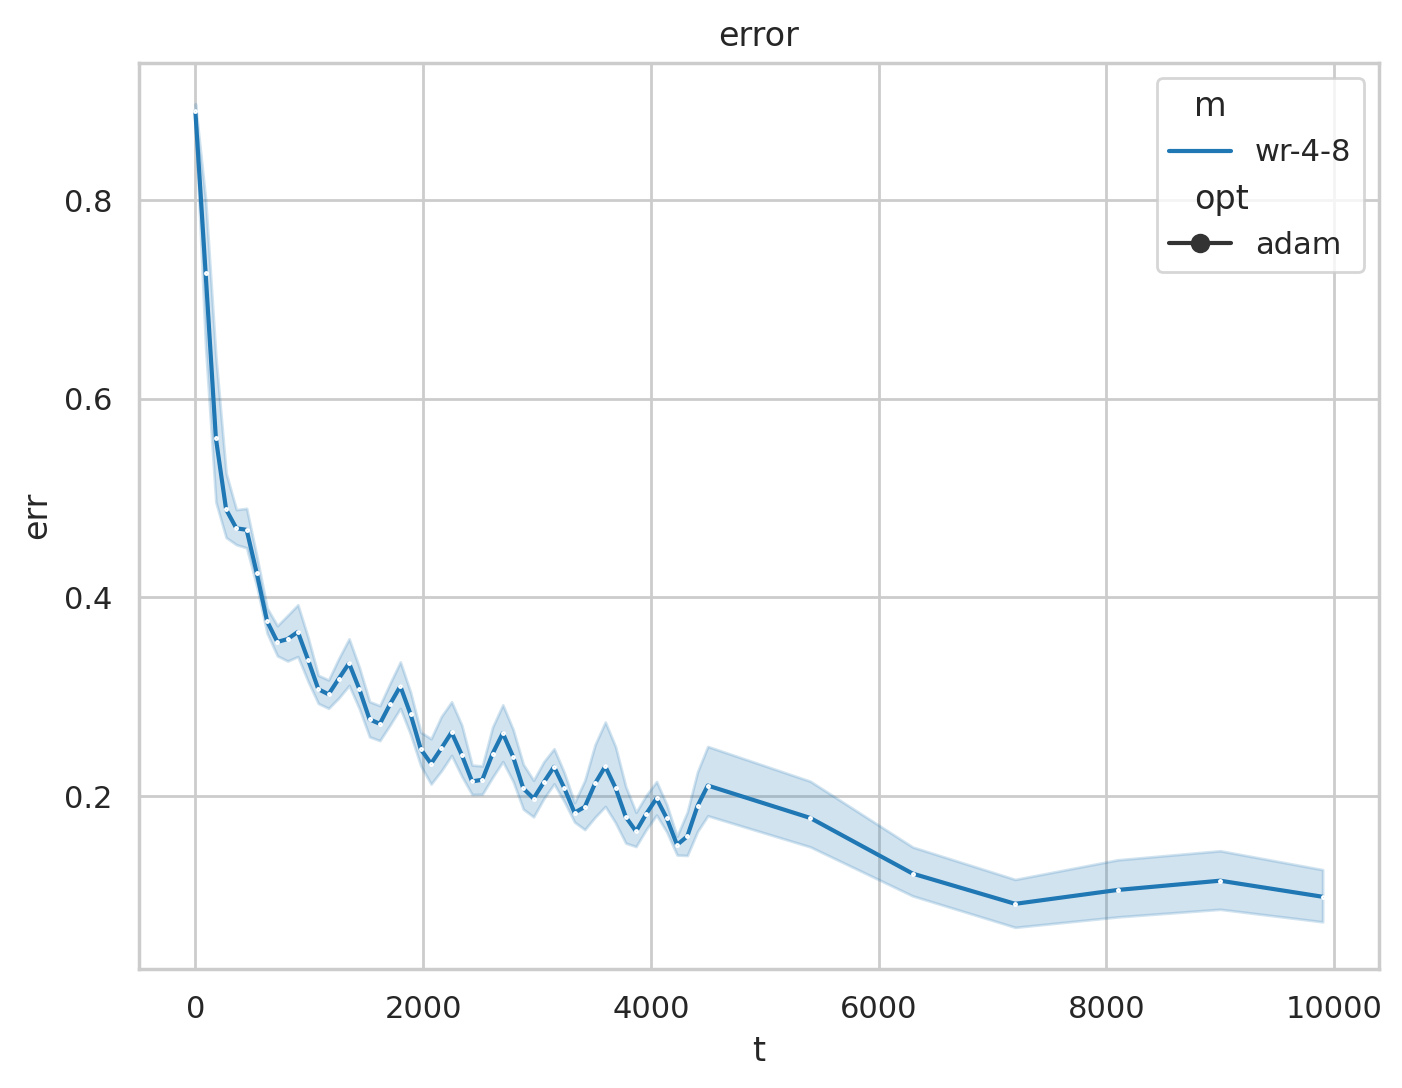

In [10]:
ax=sns.lineplot(data=d.iloc[get_idx(d, "t < 10000")], x='t', y='err', hue='m', style='opt', markers=True, markersize=1)
ax.set_title('error')

Text(0.5, 1.0, 'distance to average model')

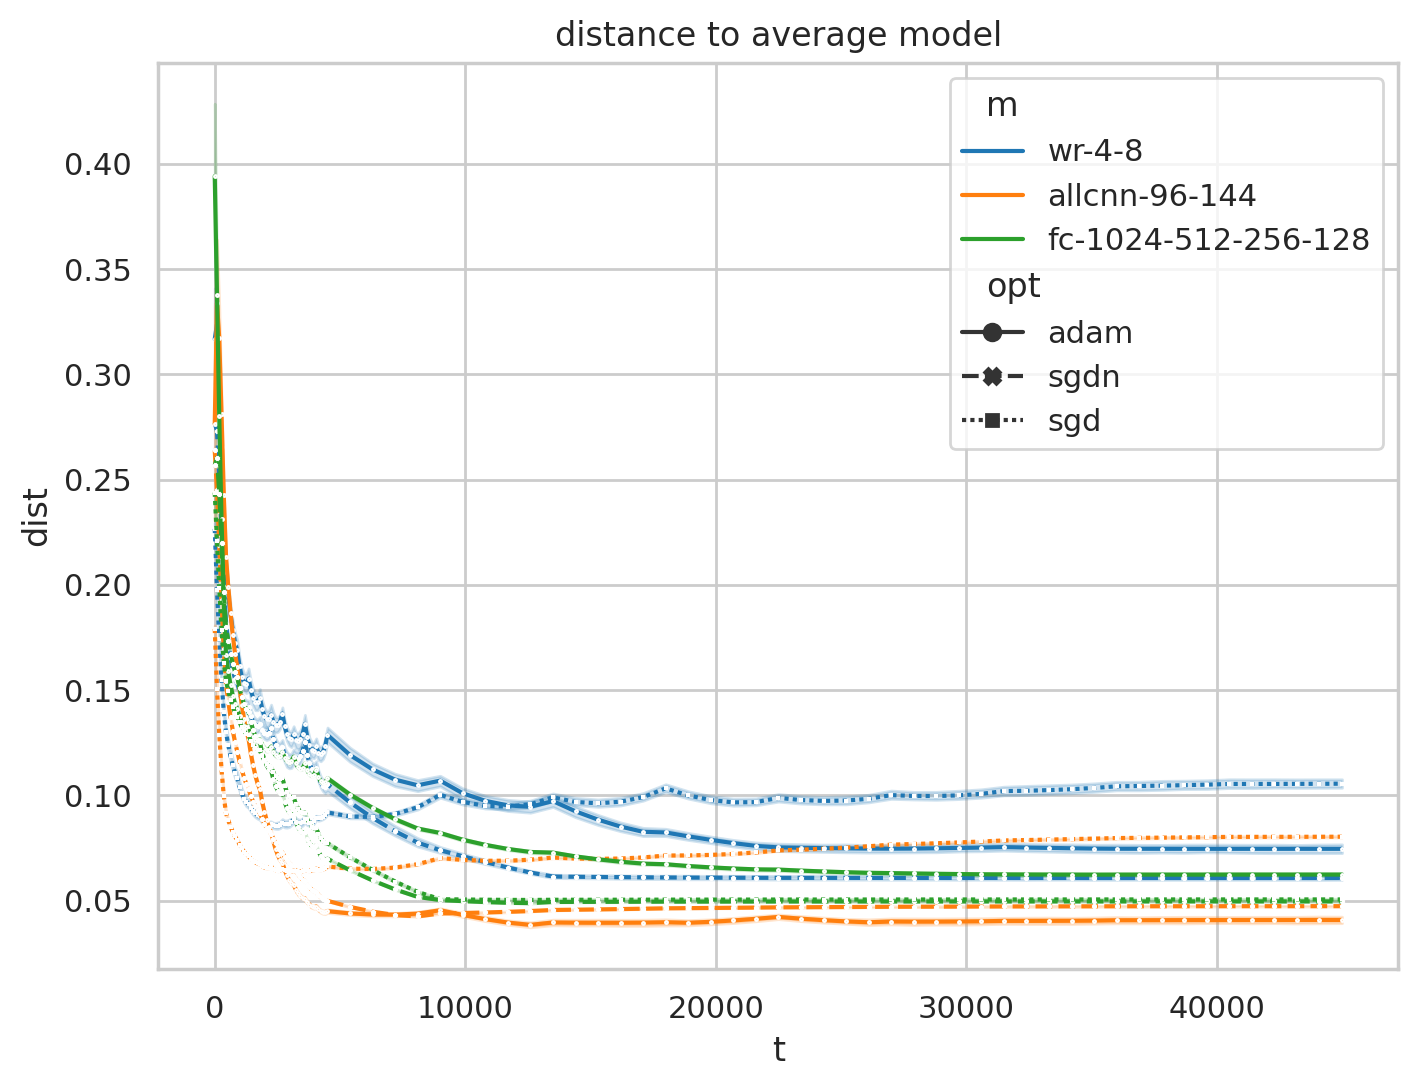

In [23]:
dists = pd.DataFrame(dists)
ax=sns.lineplot(data=dists.iloc[get_idx(dists,"key=='yh'")], x='t', y='dist', hue='m', style='opt', markers=True, markersize=1)
ax.set_title('distance to average model')

Text(0.5, 1.0, 'distance to average model')

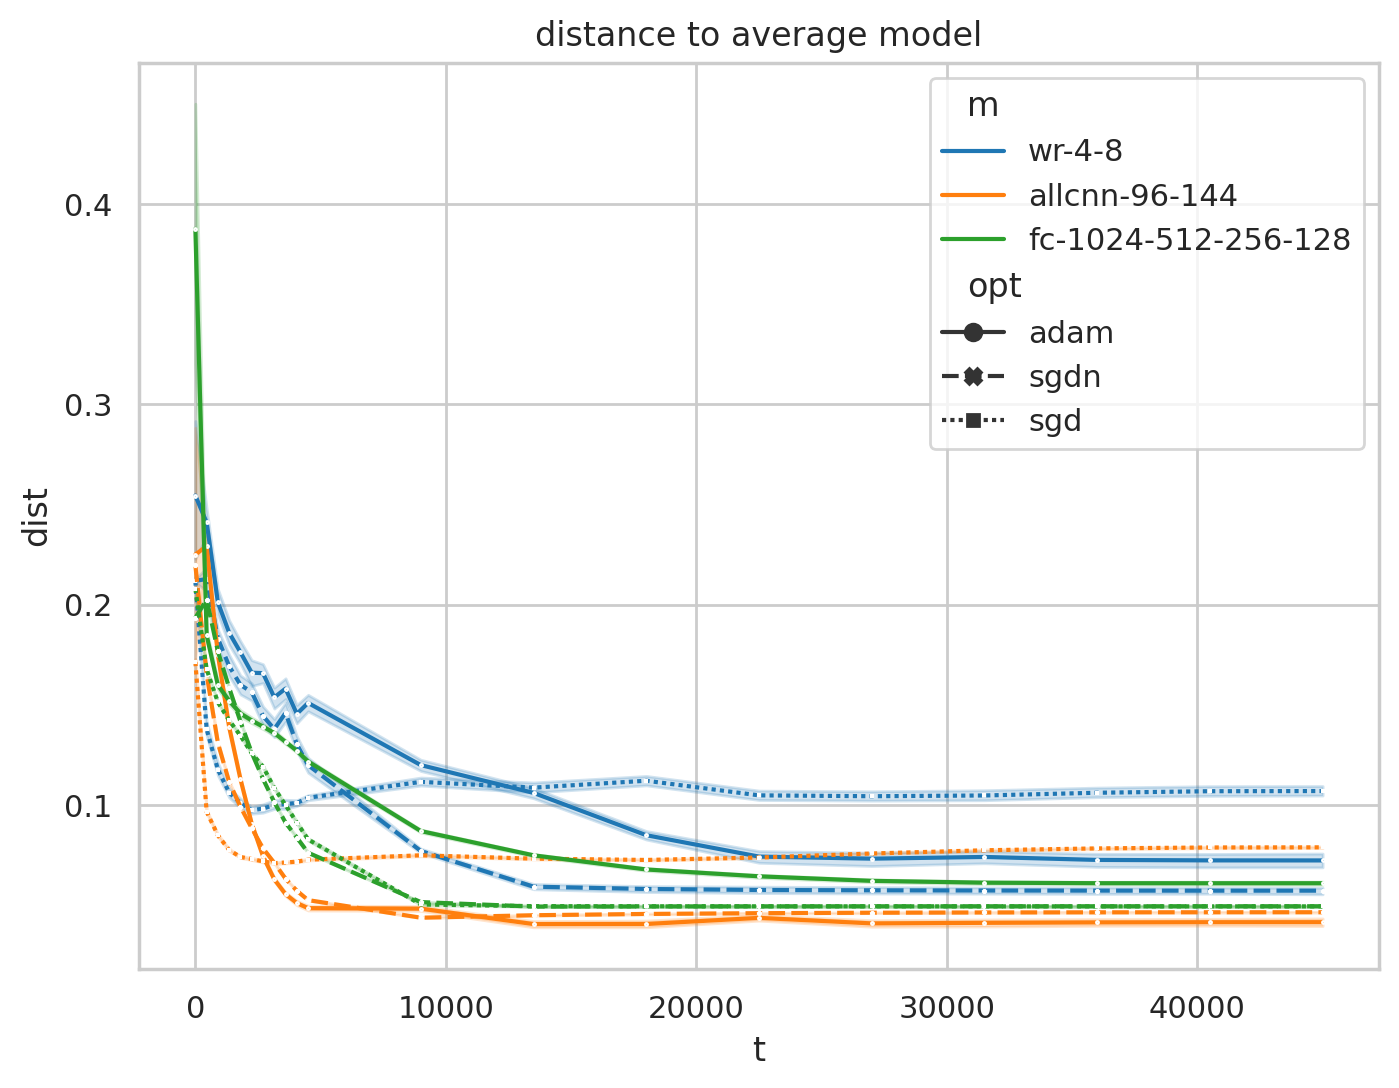

In [20]:
dists = pd.DataFrame(dists)
ax=sns.lineplot(data=dists.iloc[get_idx(dists,"key=='yh'")], x='t', y='dist', hue='m', style='opt', markers=True, markersize=1)
ax.set_title('distance to average model')

### Pairwise Distance

Text(0.5, 1.0, 'distance to average model')

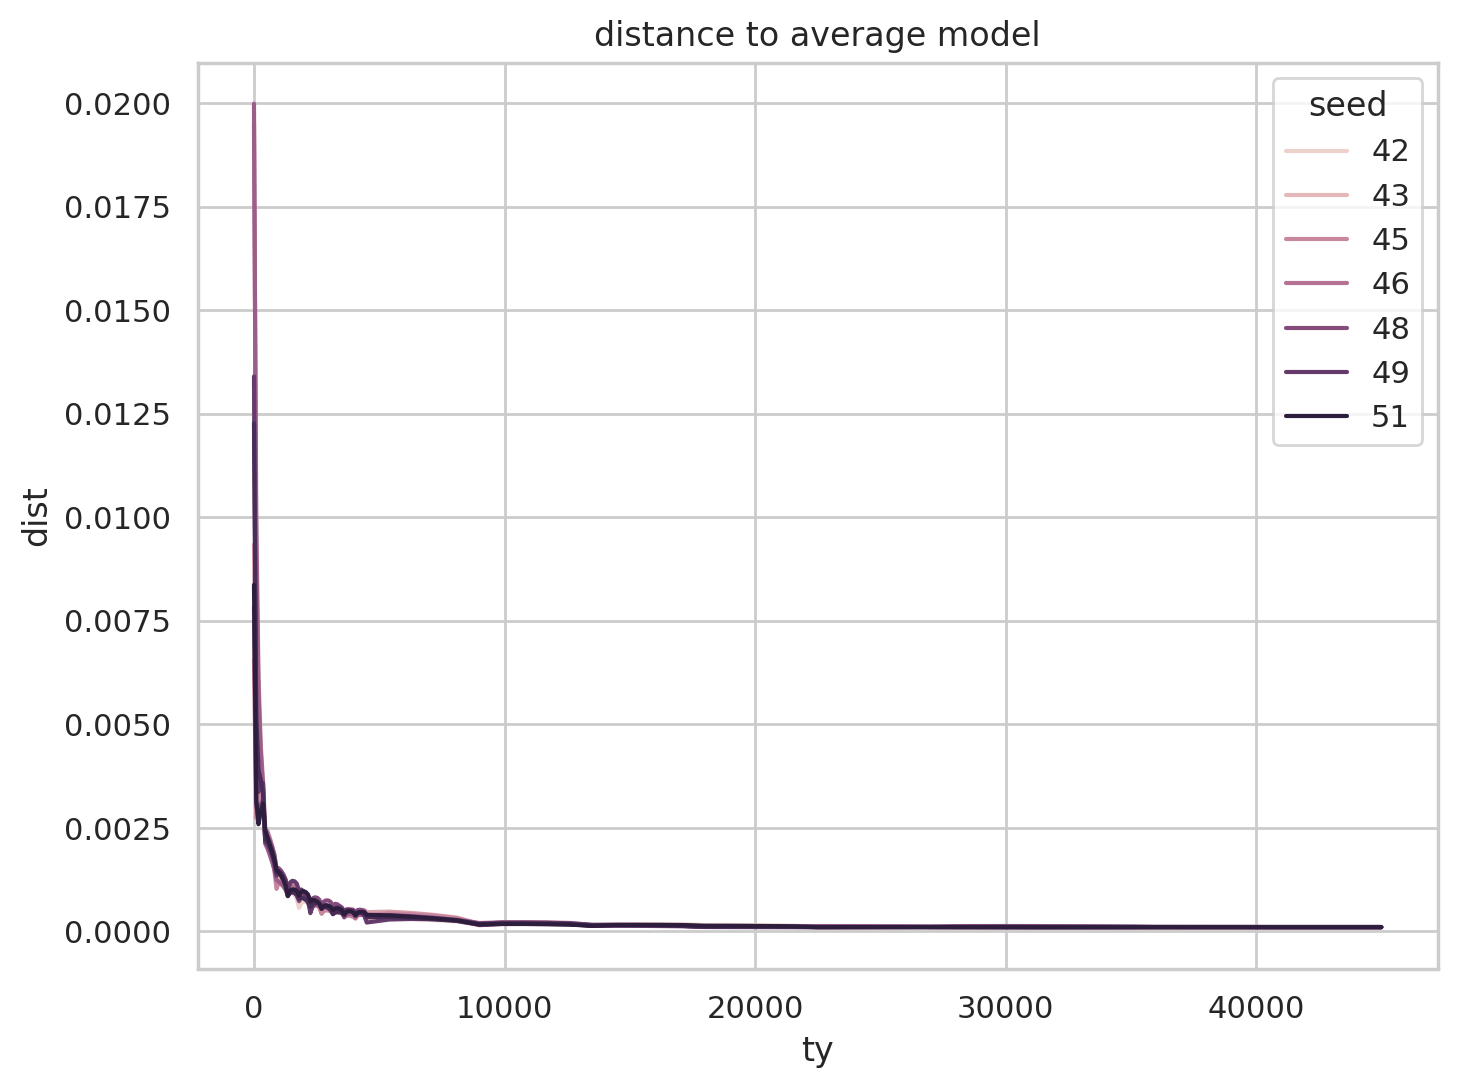

Text(0.5, 1.0, 'distance to average model')

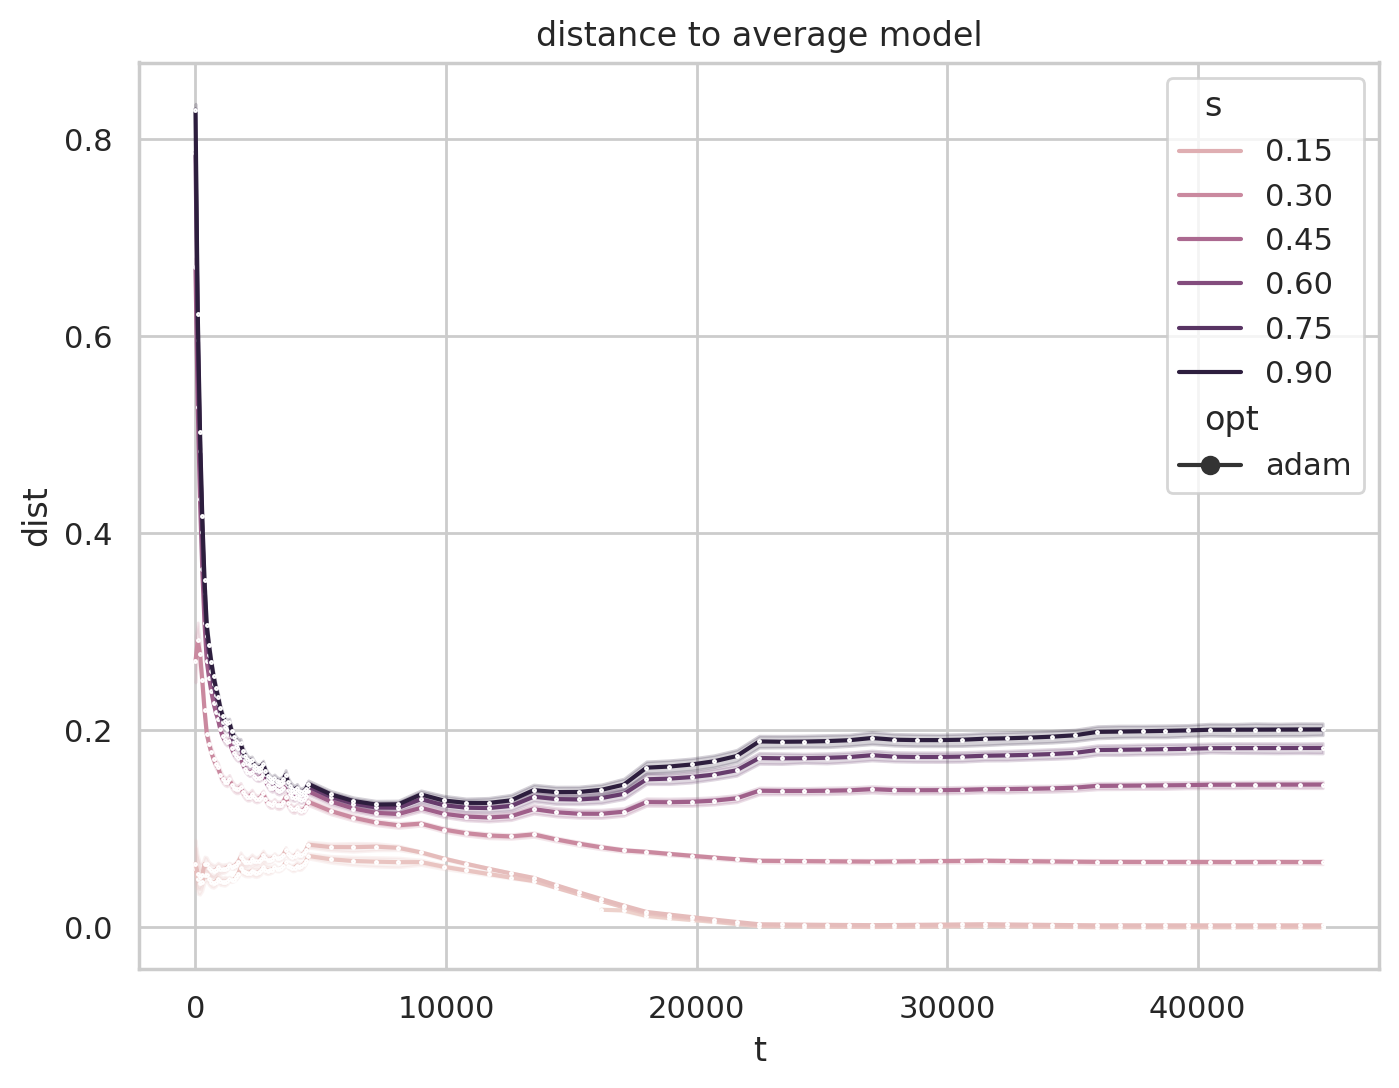

<AxesSubplot:xlabel='t', ylabel='d'>

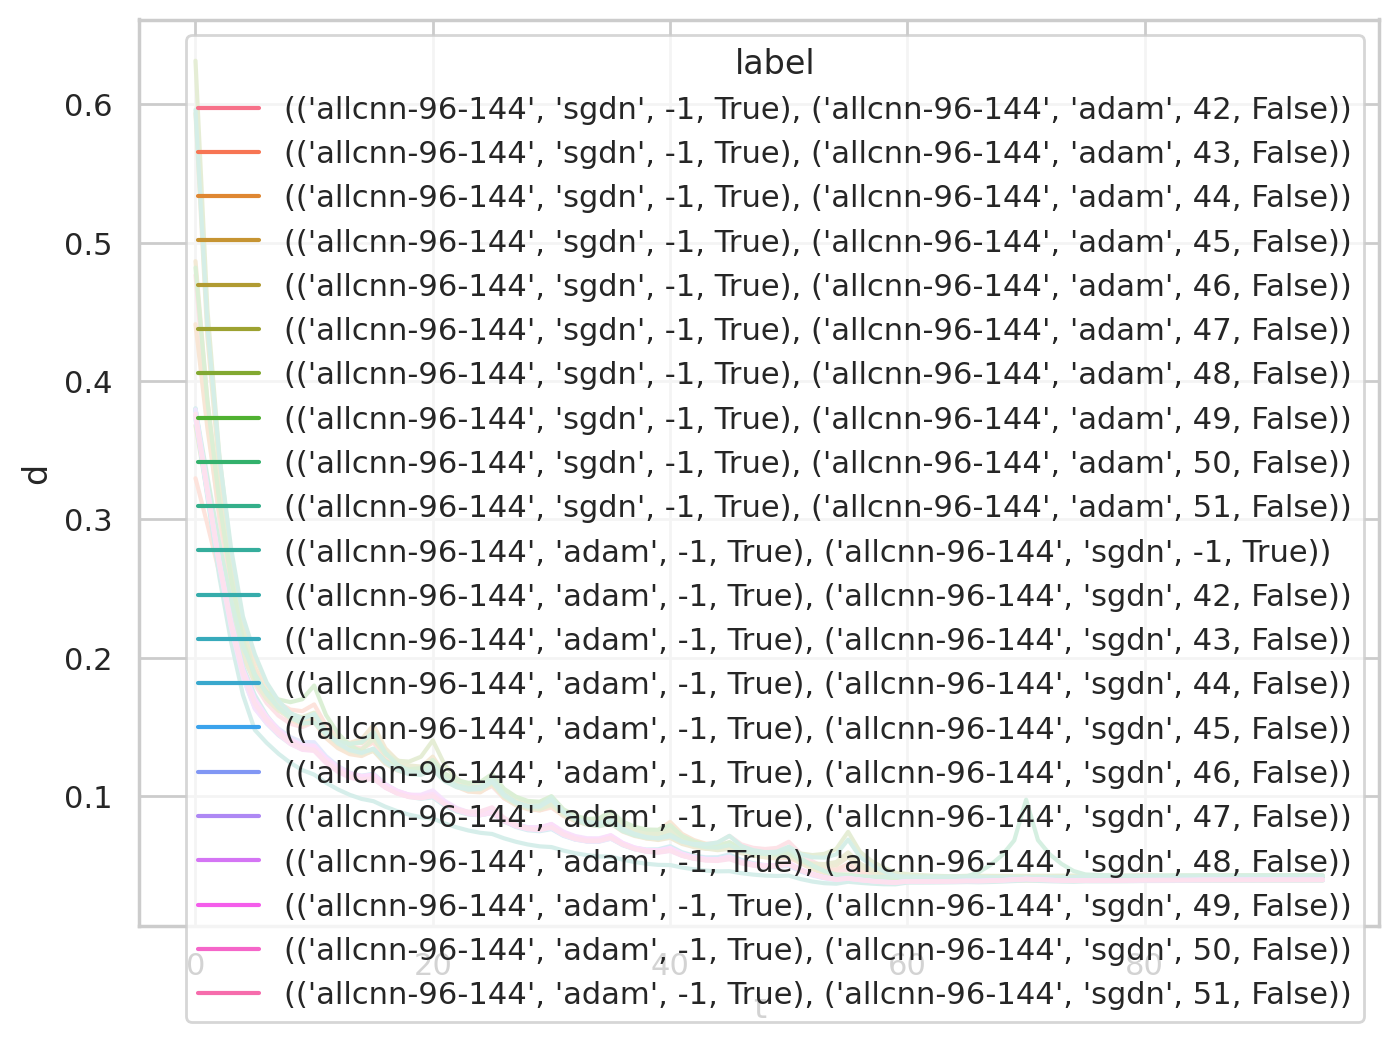

In [193]:
df = pd.DataFrame(data)
sns.lineplot(data=df, x='t', y='d', hue='label', legend=True)

<AxesSubplot:xlabel='t', ylabel='d'>

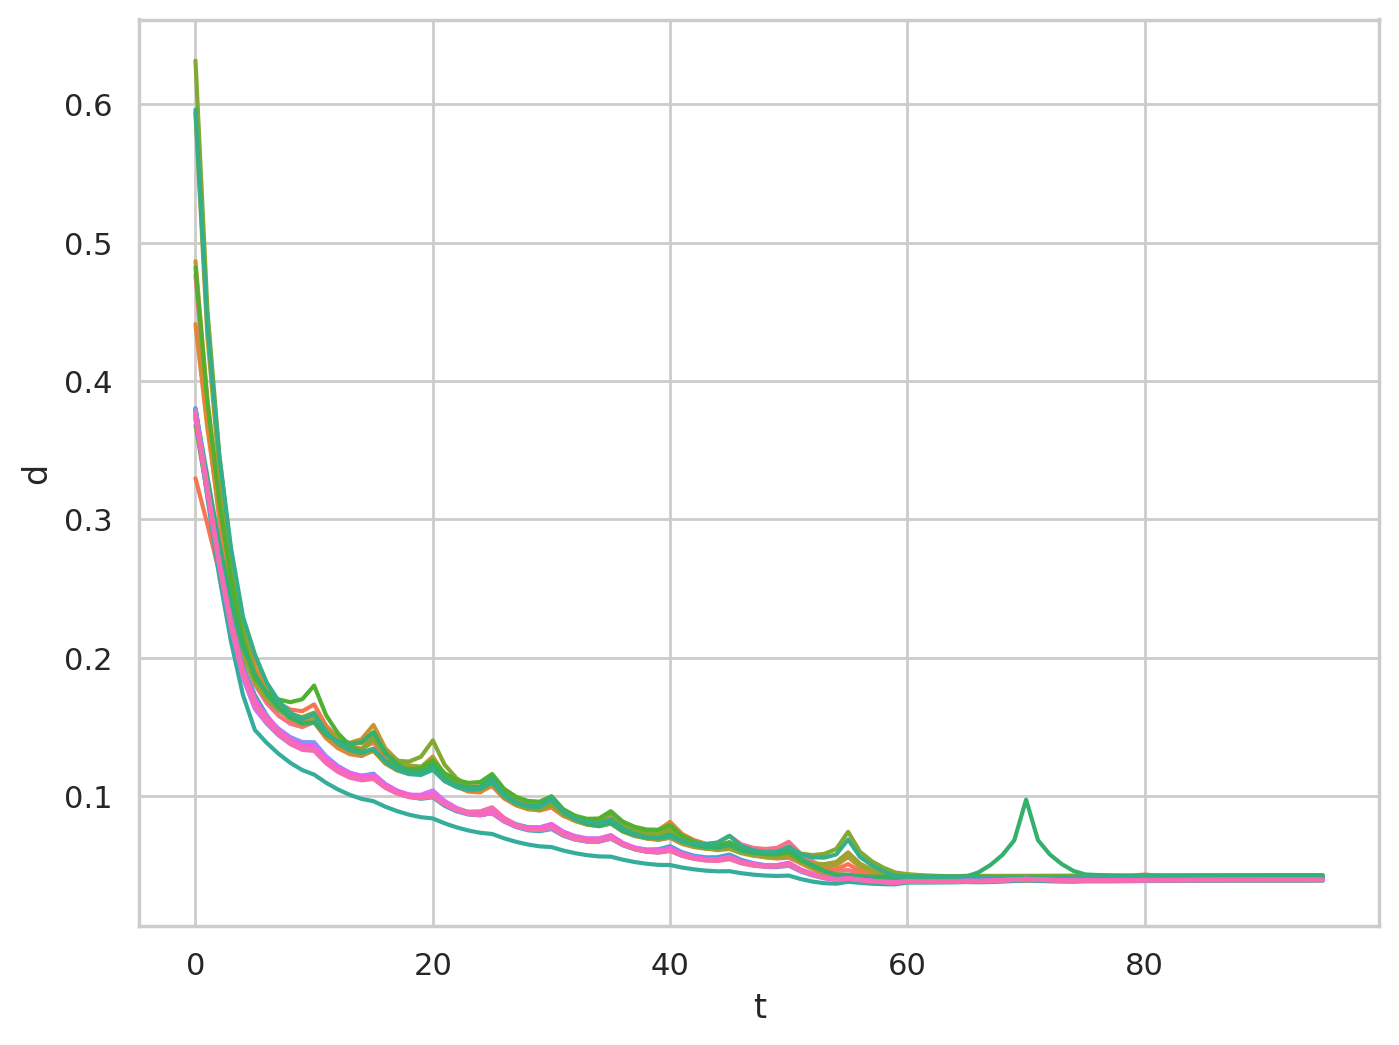

In [194]:
df = pd.DataFrame(data)
sns.lineplot(data=df, x='t', y='d', hue='label', legend=False)

<AxesSubplot:>

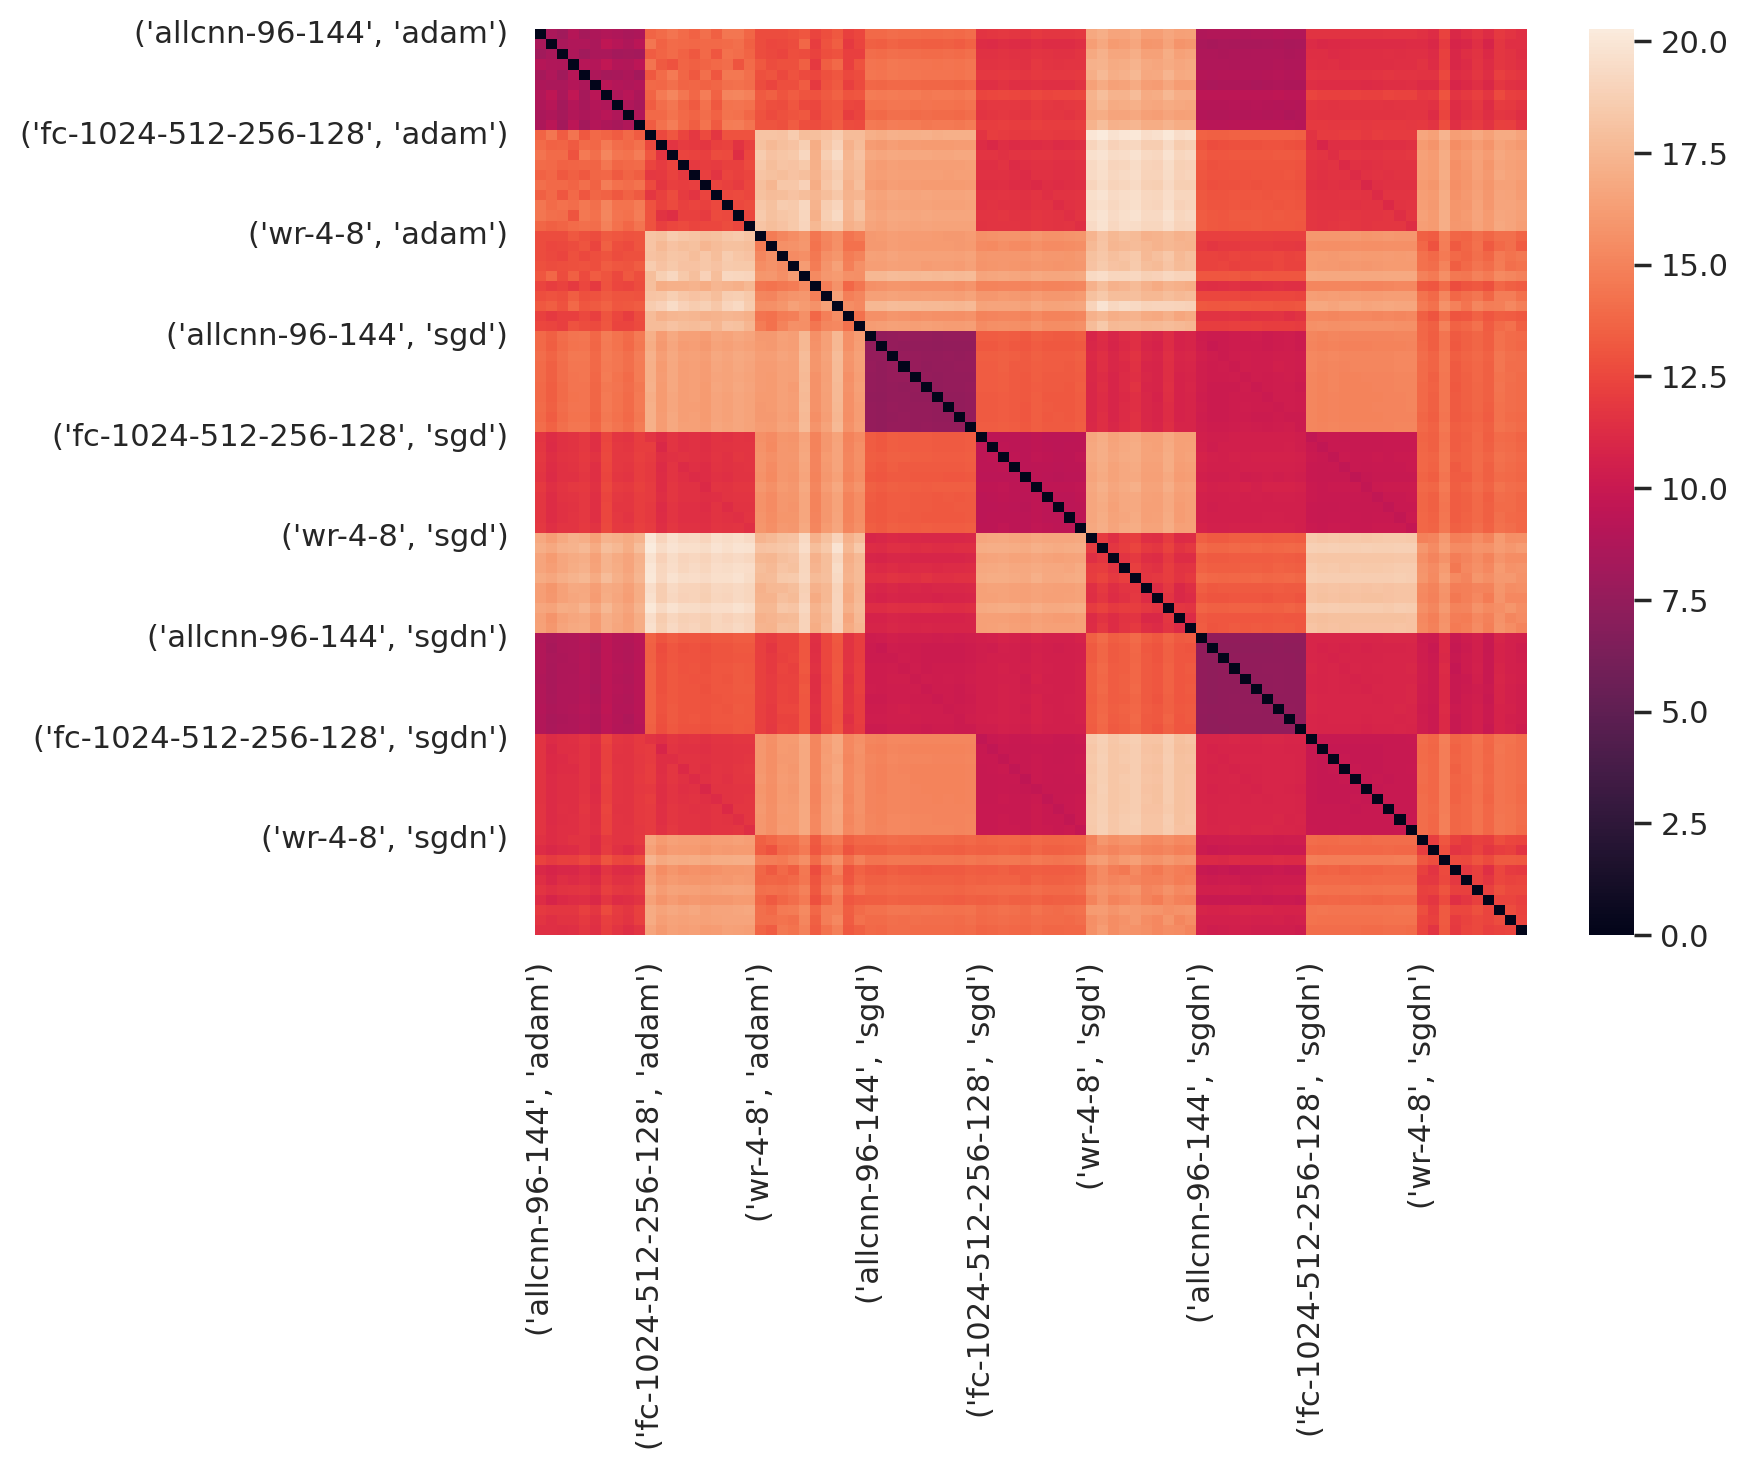

### F Test

In [58]:
def F_test_interp(d, avg, dists, fixed='m', group='opt', key='yh', distf=th.cdist, ts=range(20), pts=None,
           choices={'m': ["'wr-4-8'", "'allcnn-96-144'", "'fc-1024-512-256-128'"],
                    'opt': ["'adam'", "'sgdn'", "'sgd'"]}, verbose=False):
    F = []
    cfixed = choices[fixed]
    for c in cfixed:
        cond =  f"{fixed}=={c}"

        allm = np.stack([np.stack(d_.iloc[get_idx(d_, f"{cond} & t=={t}")][key]) for t in pts])
        om = allm.mean(1)
        om = interpn(np.expand_dims(ts, 0), om , pts)
        om = th.Tensor(om).view(len(ts), -1, 10).transpose(0, 1)
        levels = len(d_.iloc[get_idx(d_, cond)][group].unique())
        ni = len(allm) // levels

        cvar = choices[group]
        sb = 0
        for i in cvar:
            gm = np.stack(avg.iloc[get_idx(avg,  f"{cond} & {group}=={i}")][key])
            gm = interpn(np.expand_dims(ts, 0), gm, pts)
            gm = th.Tensor(gm).view(len(ts), -1, 10).transpose(0, 1)

            dbhat = -th.log(th.bmm(th.sqrt(om), th.sqrt(gm).transpose(1, 2))).mean(0)
#             m_ = th.min(dbhat[t, :], dim=0)
            p = th.exp(-dist/(2)).sum(1)
            kdist = (th.exp(-dist/(2)) * dist).sum(1) / p
            sb += kdist.cpu().numpy() * ni / (levels-1)
#         sw = (dists.iloc[get_idx(dists, f"{cond}&t=={t}&key=='{key}'")]['dist'].values).sum()/(len(allm)-levels)
   
        for (i, t) in enumerate(pts):
            sw = (dists.iloc[get_idx(dists, f"{cond}&t=={t}&key=='{key}'")]['dist'].values).sum()/(len(allm)-levels)
            if verbose:
                print('sb: ', sb[i], 'sw: ', sw)
            F.append({'sb': sb[i], 't': t, 'sw':sw, 'F': sb[i]/sw, fixed:c.strip("''")})
    return F

ValueError: need at least one array to stack

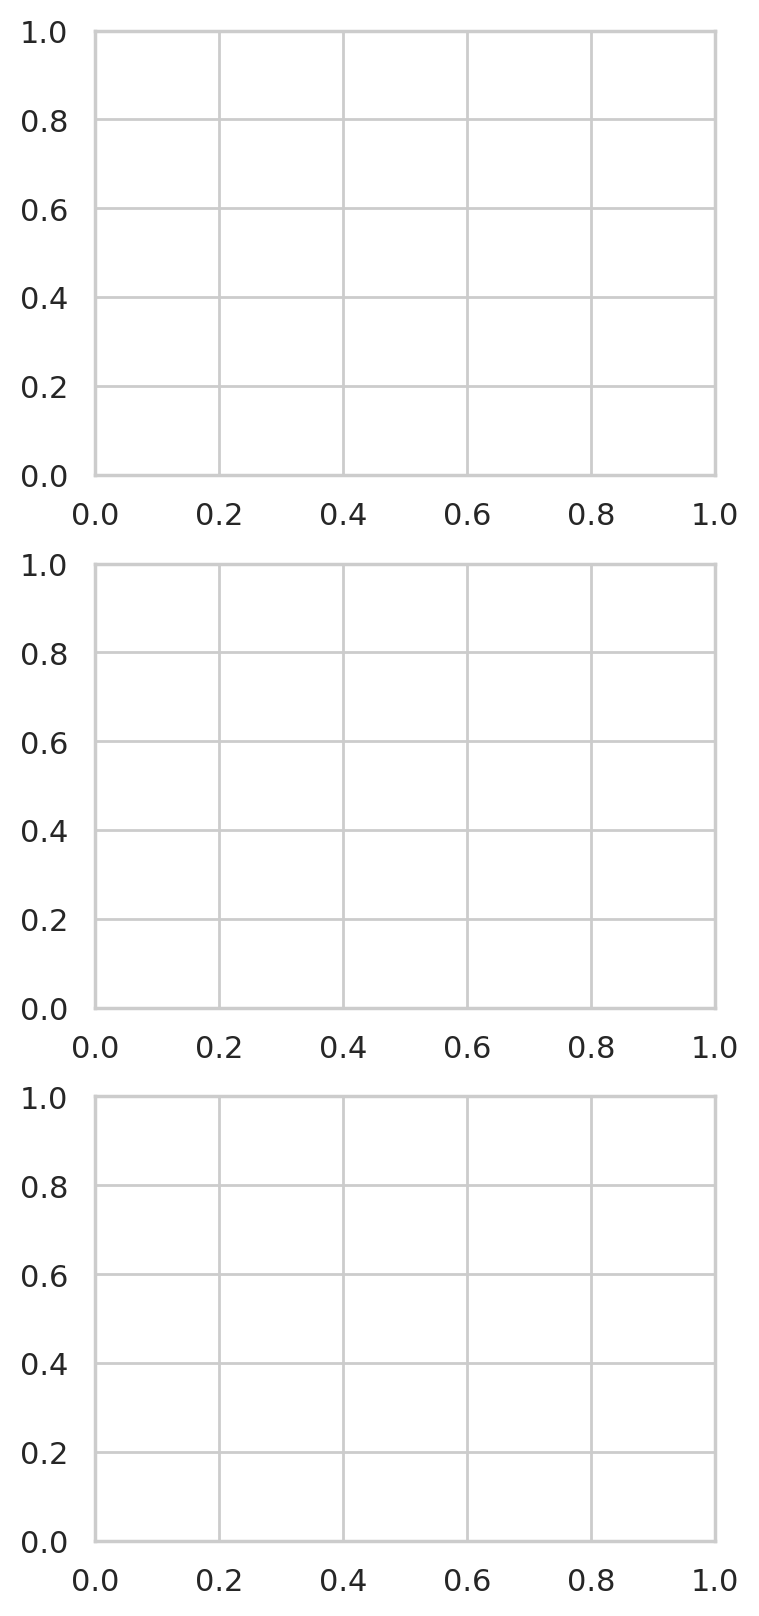

In [59]:
fig, axes = plt.subplots(3,1, figsize=(4, 10))
fixed='opt'
group='m'
F = F_test_interp(d_,
           avg,
           fixed=fixed,
           group=group,
           key="yh",
           dists=dists,
           ts=ts[0],
           pts=pts
          )
df = pd.DataFrame(F, columns=[fixed, "F", "t", "sb", "sw"])

for (i, v) in enumerate(['F', 'sb', 'sw']):
    l = True if i == 0 else False
    sns.lineplot(data=df, x="t", y=v, hue=fixed, ax=axes[i], legend=l)

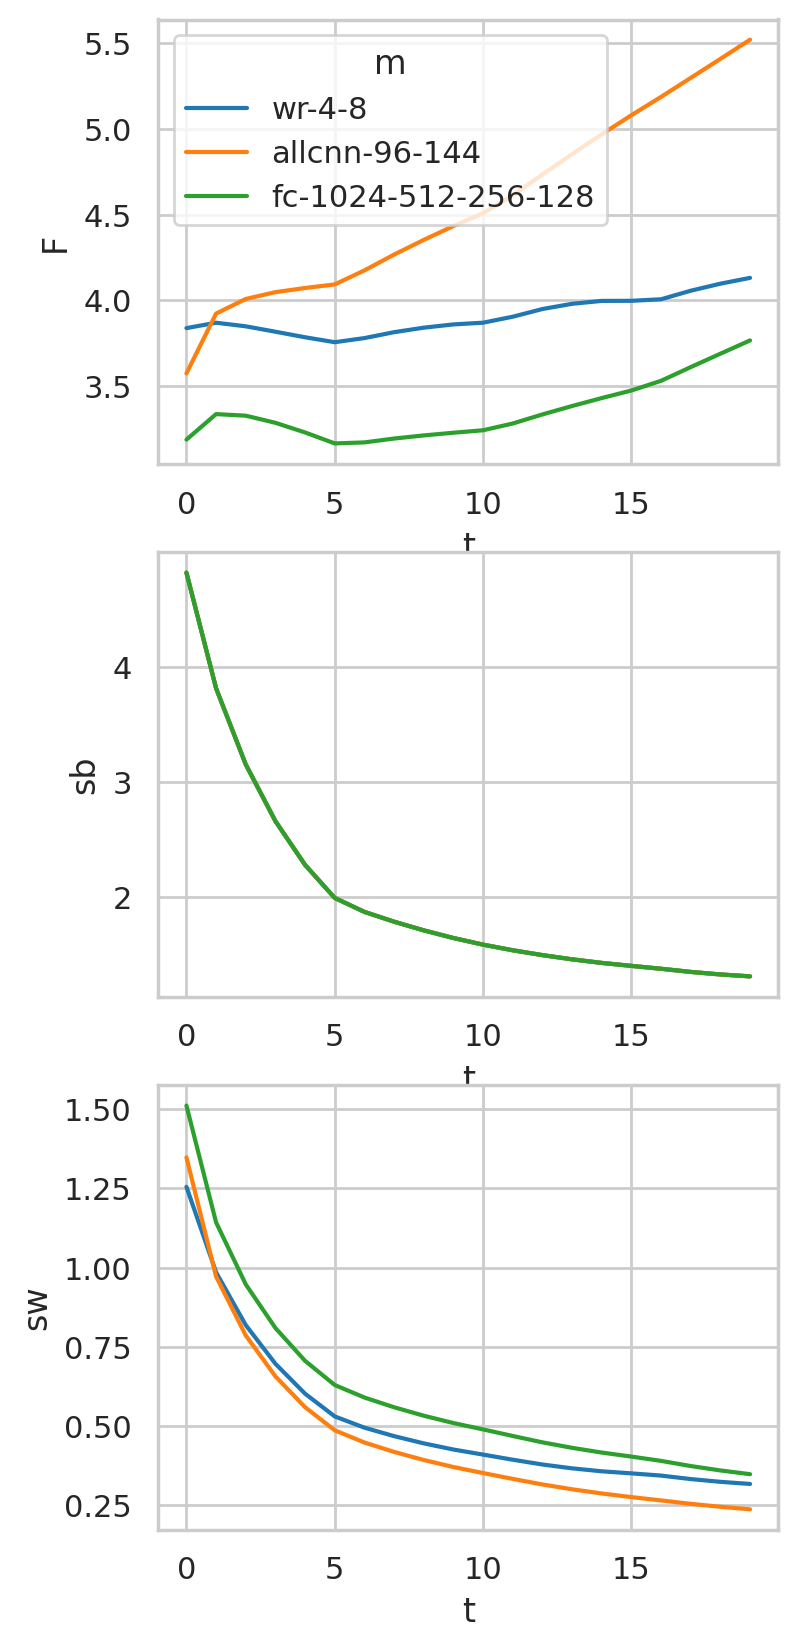

In [130]:
fig, axes = plt.subplots(3,1, figsize=(4, 10))
fixed='m'
group='opt'
F = F_test_interp(d_,
           avg,
           fixed=fixed,
           group=group,
           key="yh",
           dists=dists,
           ts=ts[0],
           pts=pts
          )
df = pd.DataFrame(F, columns=[fixed, "F", "t", "sb", "sw"])

for (i, v) in enumerate(['F', 'sb', 'sw']):
    l = True if i == 0 else False
    sns.lineplot(data=df, x="t", y=v, hue=fixed, ax=axes[i], legend=l)

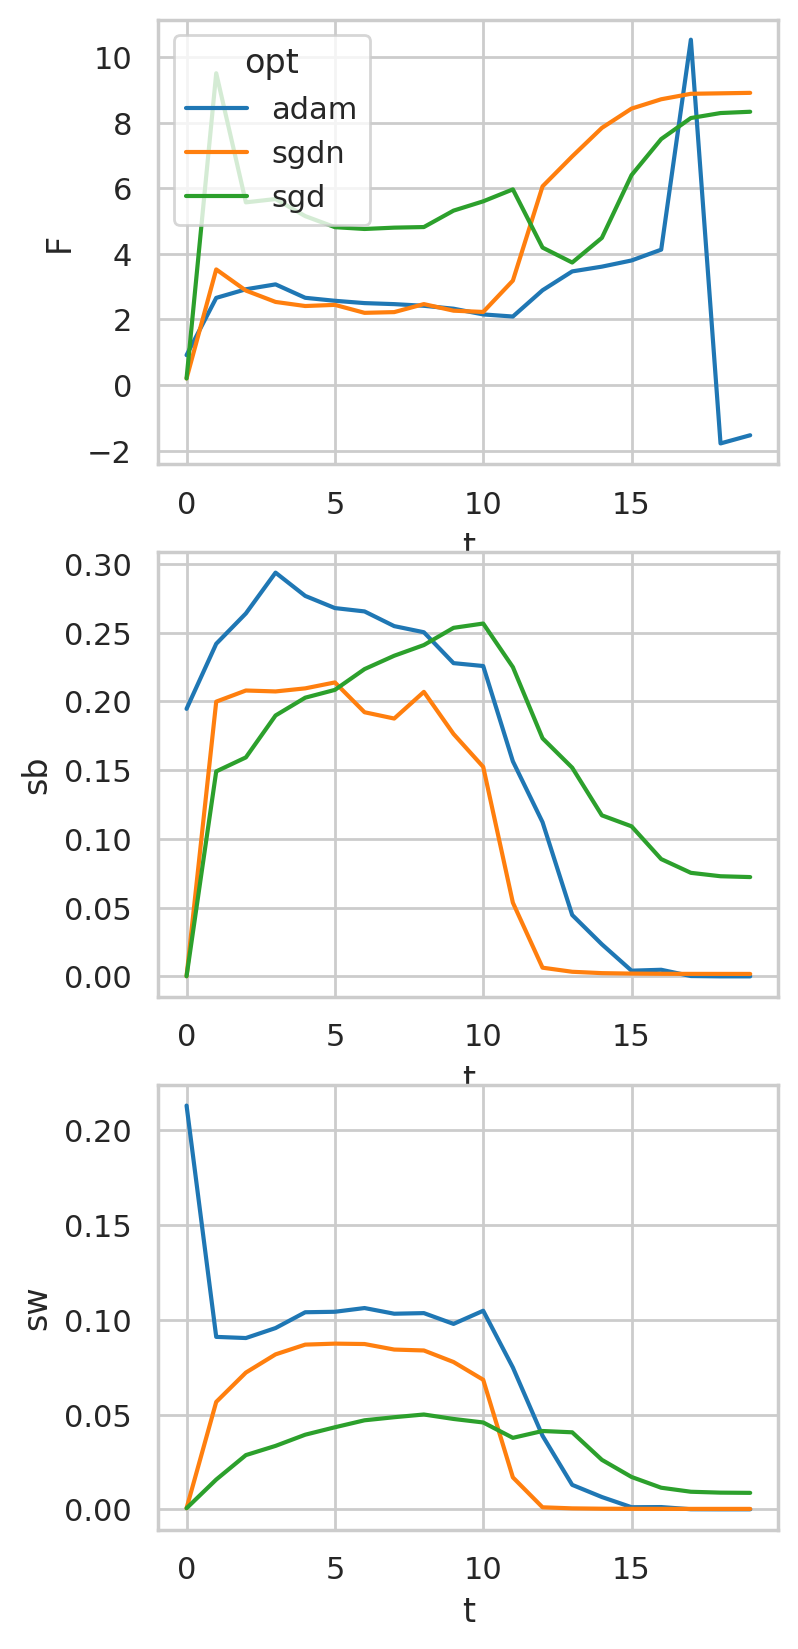

In [30]:
fig, axes = plt.subplots(3,1, figsize=(4, 10))
fixed='opt'
group='m'
F = F_test(d_,
           avg,
           fixed=fixed,
           group=group,
           key="yh",
           dists=dists)
df = pd.DataFrame(F, columns=[fixed, "F", "t", "sb", "sw"])

for (i, v) in enumerate(['F', 'sb', 'sw']):
    l = True if i == 0 else False
    sns.lineplot(data=df, x="t", y=v, hue=fixed, ax=axes[i], legend=l)

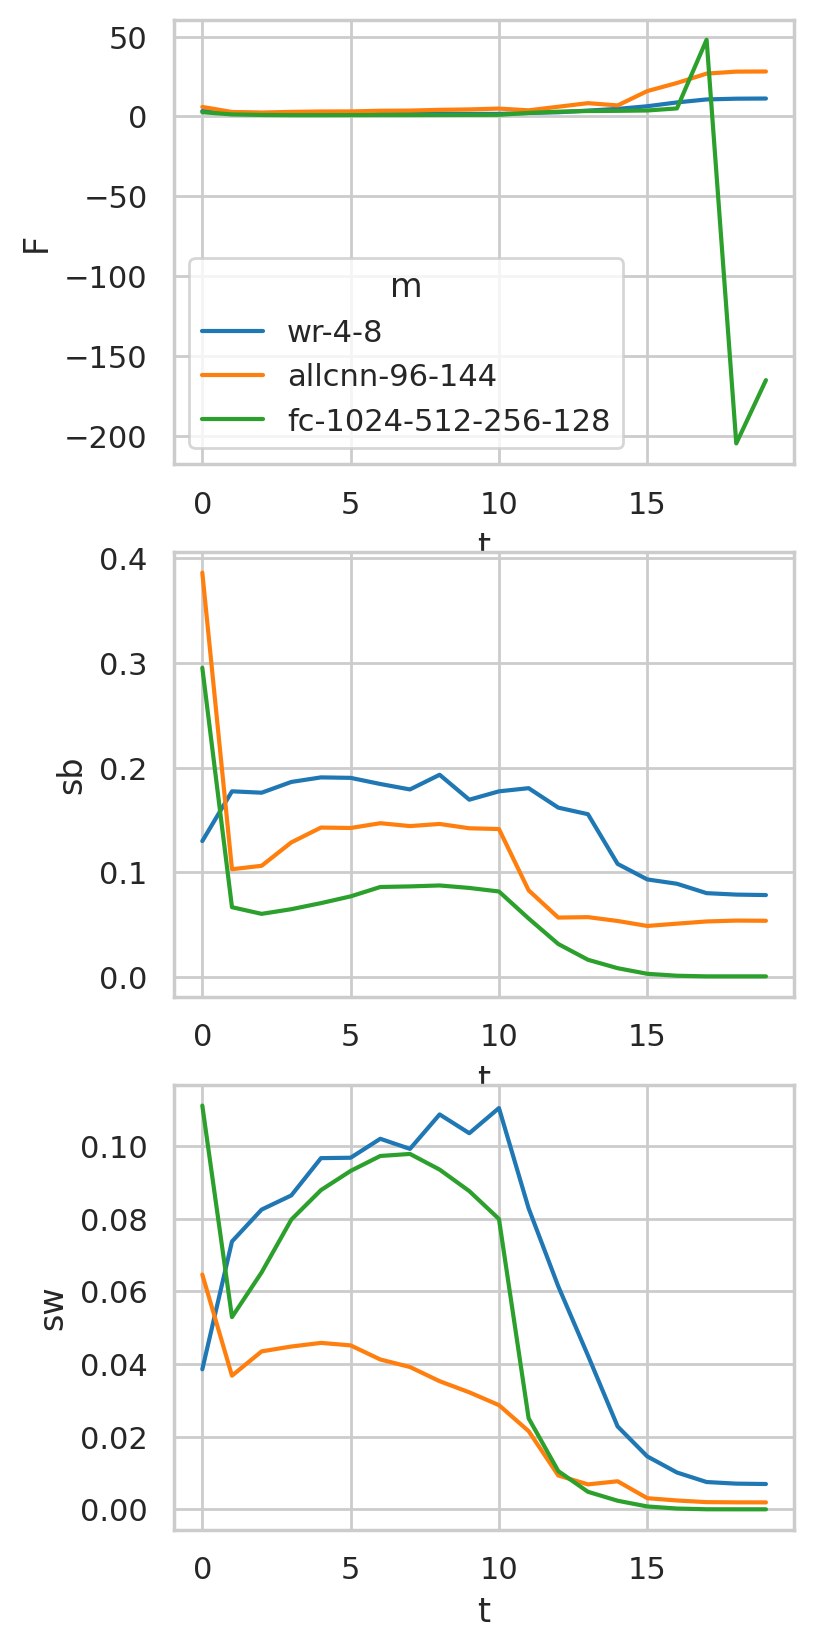

In [31]:
fig, axes = plt.subplots(3,1, figsize=(4, 10))
fixed='m'
group='opt'
F = F_test(d_,
           avg,
           fixed=fixed,
           group=group,
           key="yh",
           dists=dists)
df = pd.DataFrame(F, columns=[fixed, "F", "t", "sb", "sw"])

for (i, v) in enumerate(['F', 'sb', 'sw']):
    l = True if i == 0 else False
    sns.lineplot(data=df, x="t", y=v, hue=fixed, ax=axes[i], legend=l)

## Point Distance

### F-test

In [105]:
loc = 'results/models/new'
d = load_d(loc, cond={'bs':200, 'aug':True, 'wd':0.0, 'bn':True}, avg_err=True)
d = d[d['m'].isin([m.strip("''") for m in models])]
d_ = drop_untrained(d, key='err', th=0.01, verbose=False).reset_index()
del d

Index(['seed', 'm', 'opt', 'lr', 'wd', 'bn', 'aug', 'bs', 't', 'yh', 'f', 'e',
       'yvh', 'fv', 'ev', 'err', 'verr', 'favg', 'vfavg'],
      dtype='object') 1960


In [106]:
bdist = lambda x1, x2: -th.log(th.bmm(th.sqrt(x1), th.sqrt(x2).transpose(1, 2)))
avg, dists = avg_model(d_, groupby=['m', 'opt', 'bn', 't'], probs=False, get_err=True, 
                       compute_distance=True, distf=bdist, dev='cuda')

Text(0.5, 1.0, 'distance to average model')

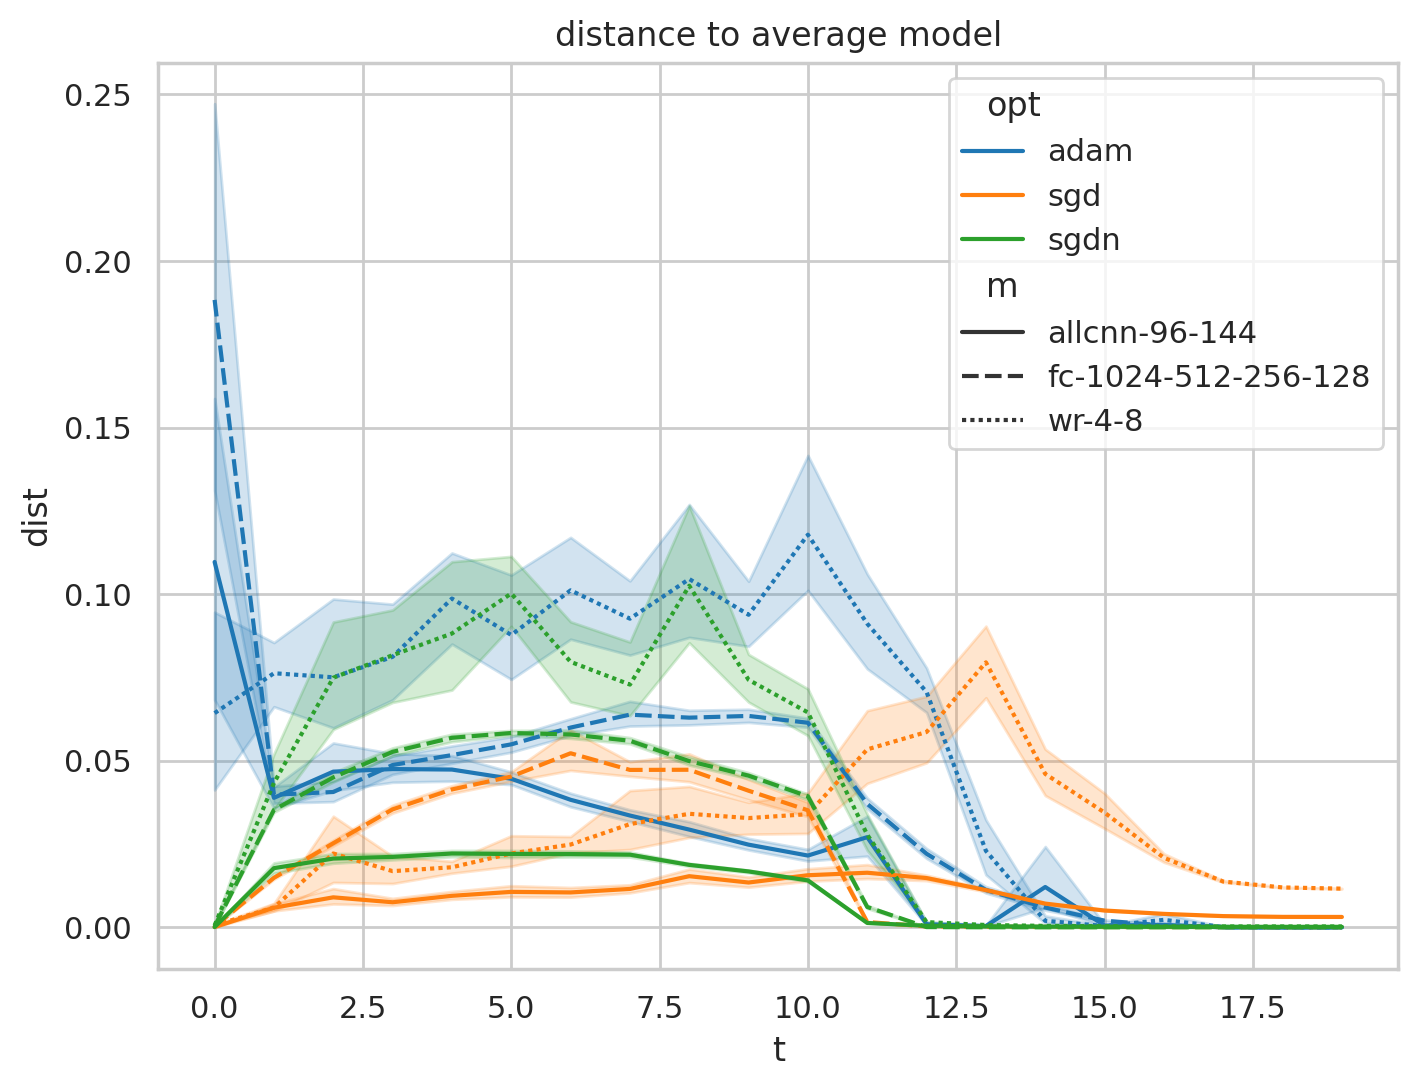

In [107]:
# dists = pd.DataFrame(dists)
ax=sns.lineplot(data=dists[dists['key'] == 'yh'], x='t', y='dist', hue='opt', style='m')
ax.set_title('distance to average model')

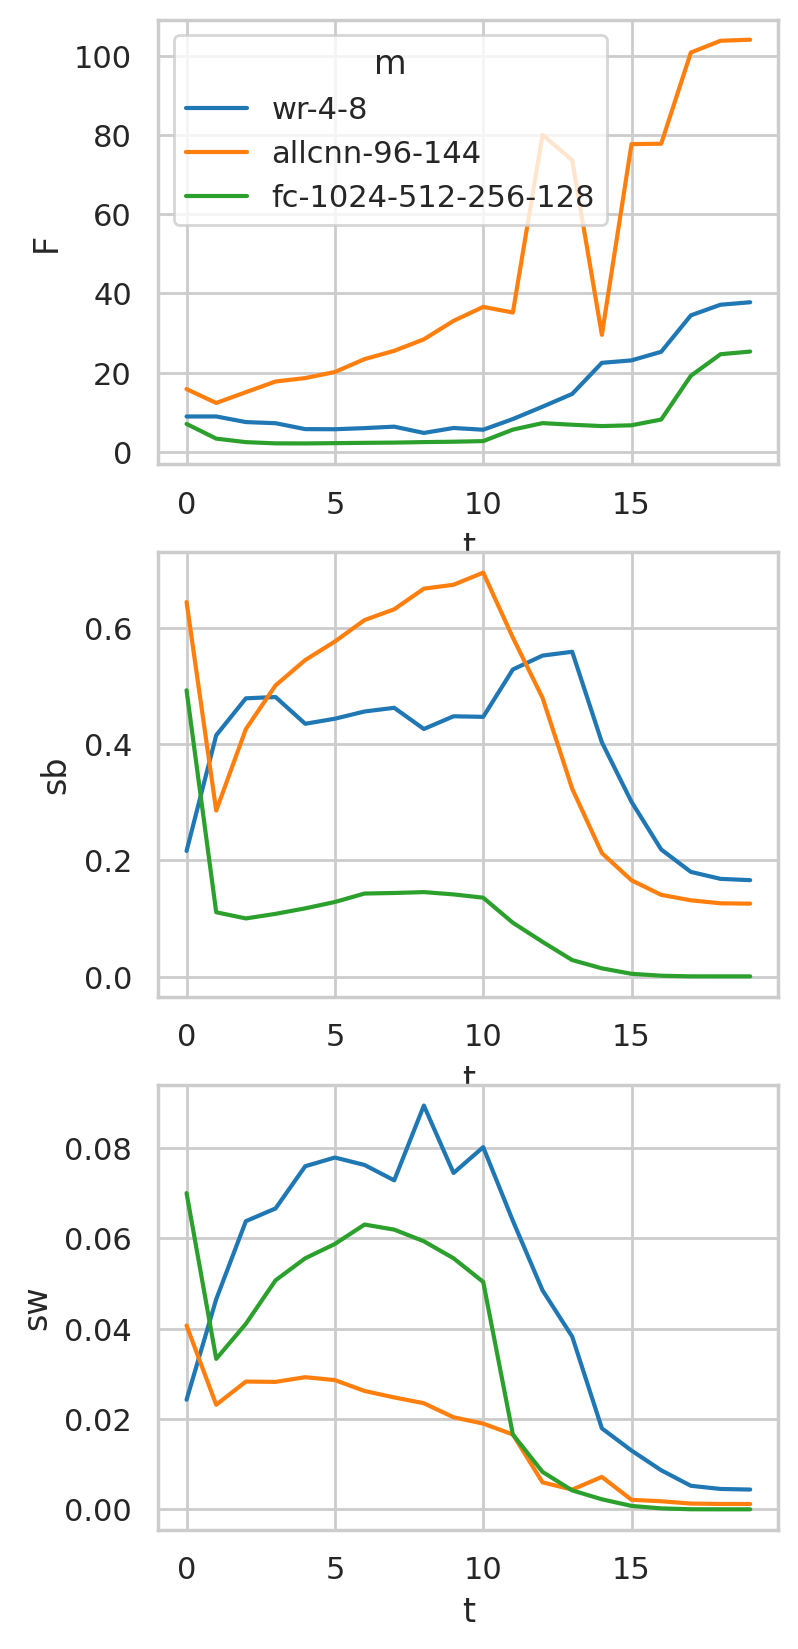

In [108]:
from utils import F_test
fig, axes = plt.subplots(3,1, figsize=(4, 10))
fixed='m'
group='opt'
F = F_test(d_,
           avg,
           fixed=fixed,
           group=group,
           key="yh",
           distf=bdist,
           dists=dists)
df = pd.DataFrame(F, columns=[fixed, "F", "t", "sb", "sw"])

for (i, v) in enumerate(['F', 'sb', 'sw']):
    l = True if i == 0 else False
    sns.lineplot(data=df, x="t", y=v, hue=fixed, ax=axes[i], legend=l)

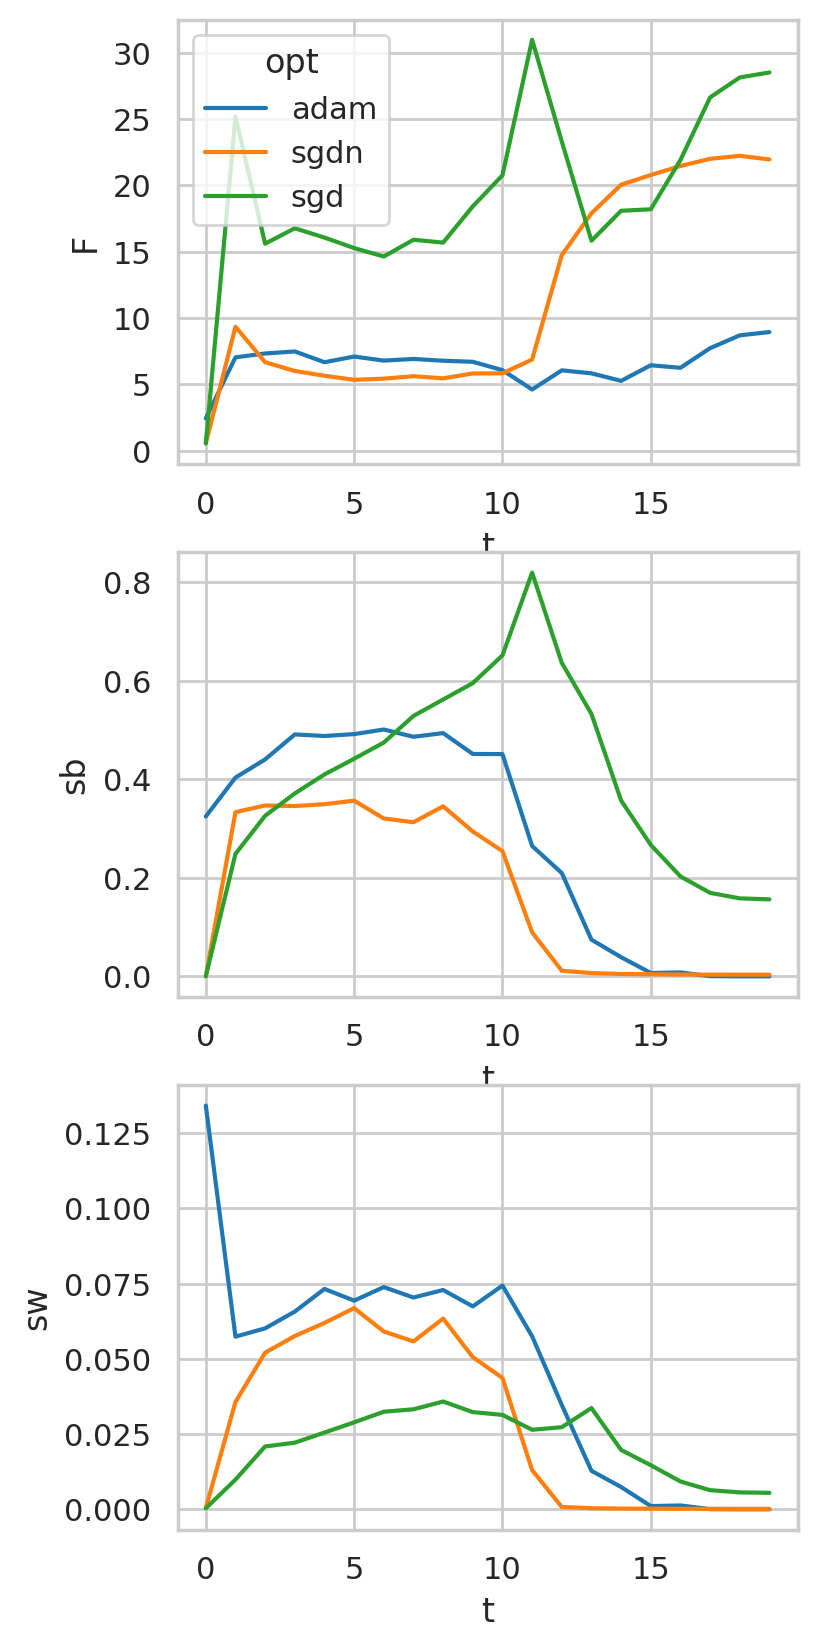

In [109]:
from utils import F_test
fig, axes = plt.subplots(3,1, figsize=(4, 10))
fixed='opt'
group='m'
F = F_test(d_,
           avg,
           fixed=fixed,
           group=group,
           key="yh",
           distf=bdist,
           dists=dists)
df = pd.DataFrame(F, columns=[fixed, "F", "t", "sb", "sw"])

for (i, v) in enumerate(['F', 'sb', 'sw']):
    l = True if i == 0 else False
    sns.lineplot(data=df, x="t", y=v, hue=fixed, ax=axes[i], legend=l)

## euclidean-dist

In [121]:
loc = 'results/models/new'
d = load_d(loc, cond={'bs':200, 'aug':True, 'wd':0.0, 'bn':True}, avg_err=True, numpy=True, probs=False)
d_ = drop_untrained(d, key='err', th=0.01, verbose=False).reset_index()
del d

Index(['seed', 'm', 'opt', 'lr', 'wd', 'bn', 'aug', 'bs', 't', 'yh', 'f', 'e',
       'yvh', 'fv', 'ev', 'err', 'verr', 'favg', 'vfavg'],
      dtype='object') 1800


In [122]:
edist = lambda x1, x2: th.cdist(x1, x2)**2
avg, dists = avg_model(d_, groupby=['m', 'opt', 't'], probs=False, get_err=False,
                       compute_distance=True, distf=bdist, dev='cuda')

<AxesSubplot:xlabel='t', ylabel='F'>

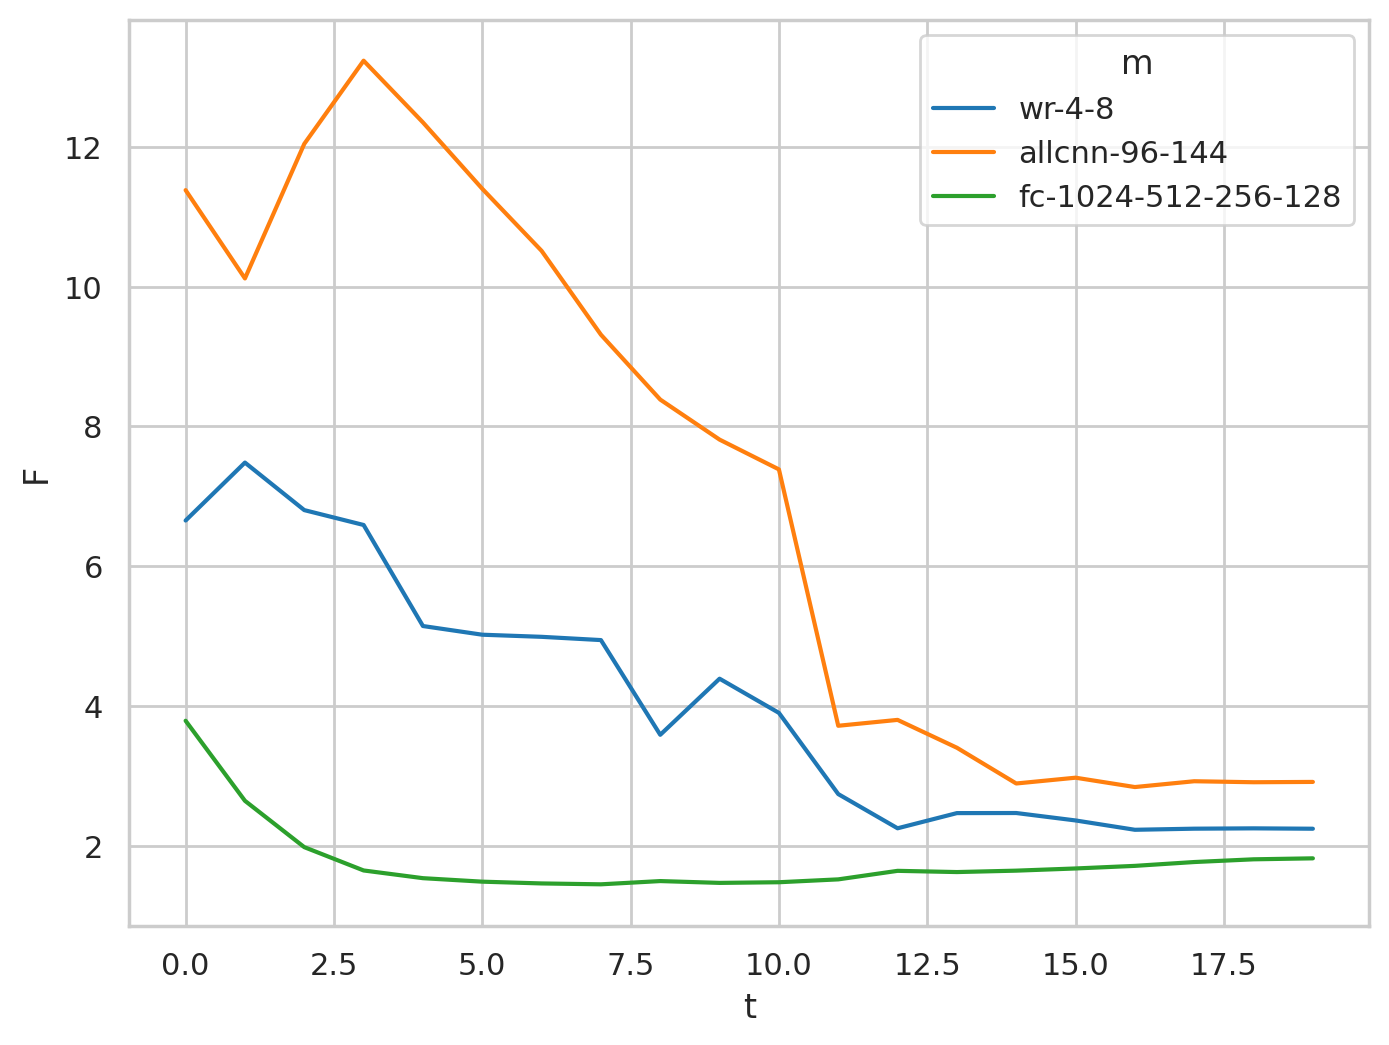

In [23]:
F = F_test(d_,
           avg,
           fixed="m",
           key="yvh",
           distf=edist,
           dists=dists,
           verbose=False)
df = pd.DataFrame(F, columns=["m", "F", "t", "sb", "sw"])
sns.lineplot(data=df, x="t", y="F", hue="m")

<AxesSubplot:xlabel='t', ylabel='F'>

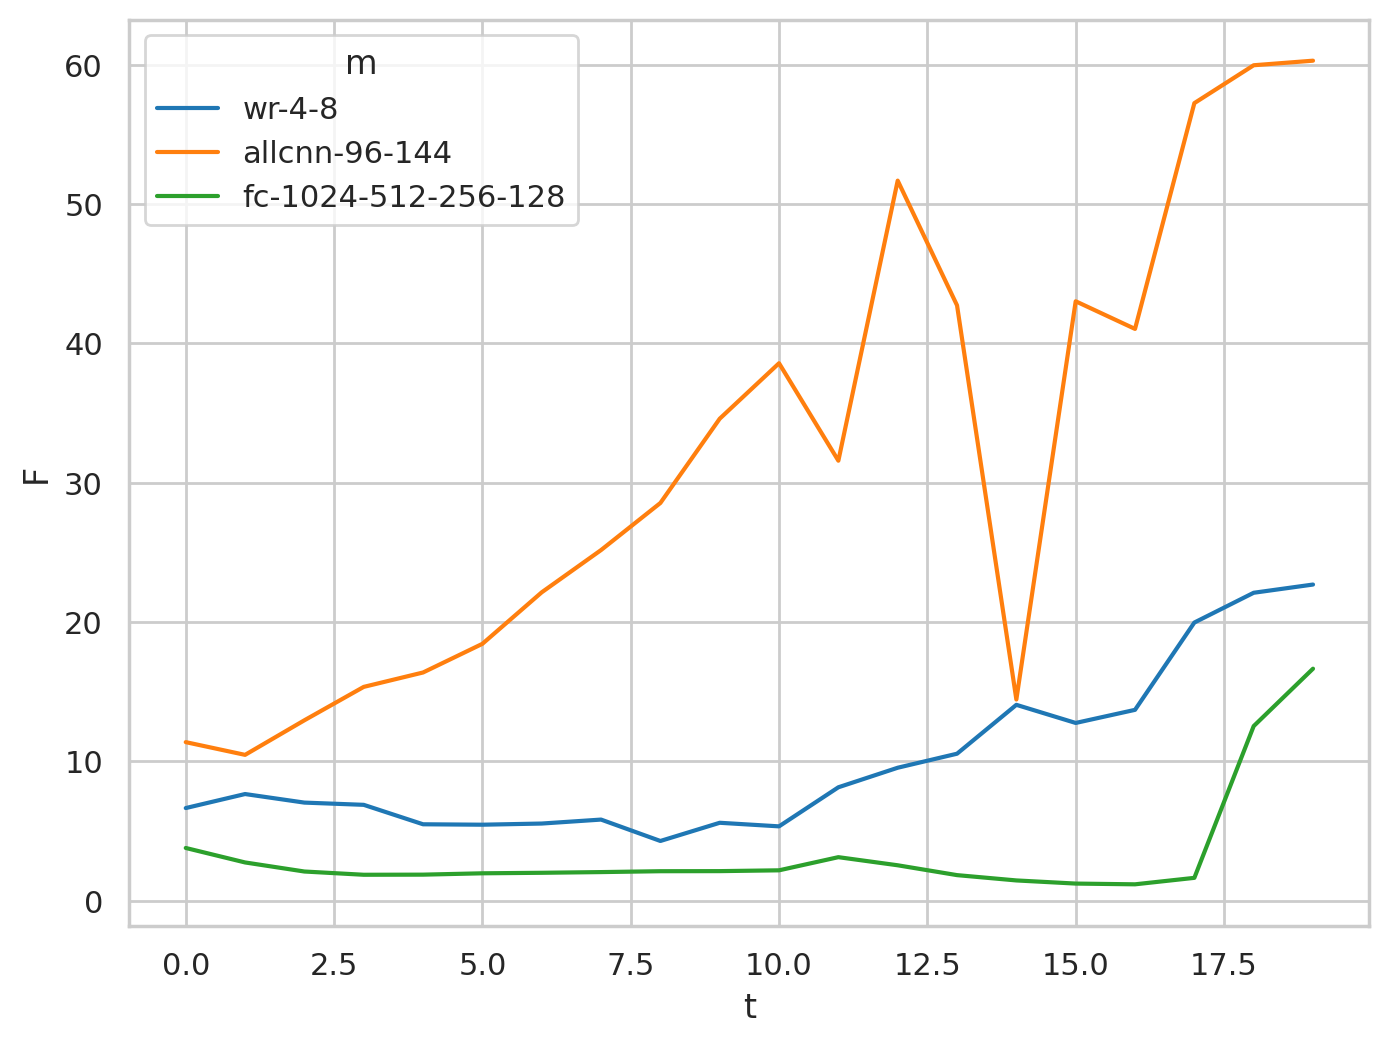

In [24]:
F = F_test(d_,
           avg,
           fixed="m",
           key="yh",
           distf=edist,
           dists=dists,
           verbose=False)
df = pd.DataFrame(F, columns=["m", "F", "t", "sb", "sw"])
sns.lineplot(data=df, x="t", y="F", hue="m")

<AxesSubplot:xlabel='t', ylabel='F'>

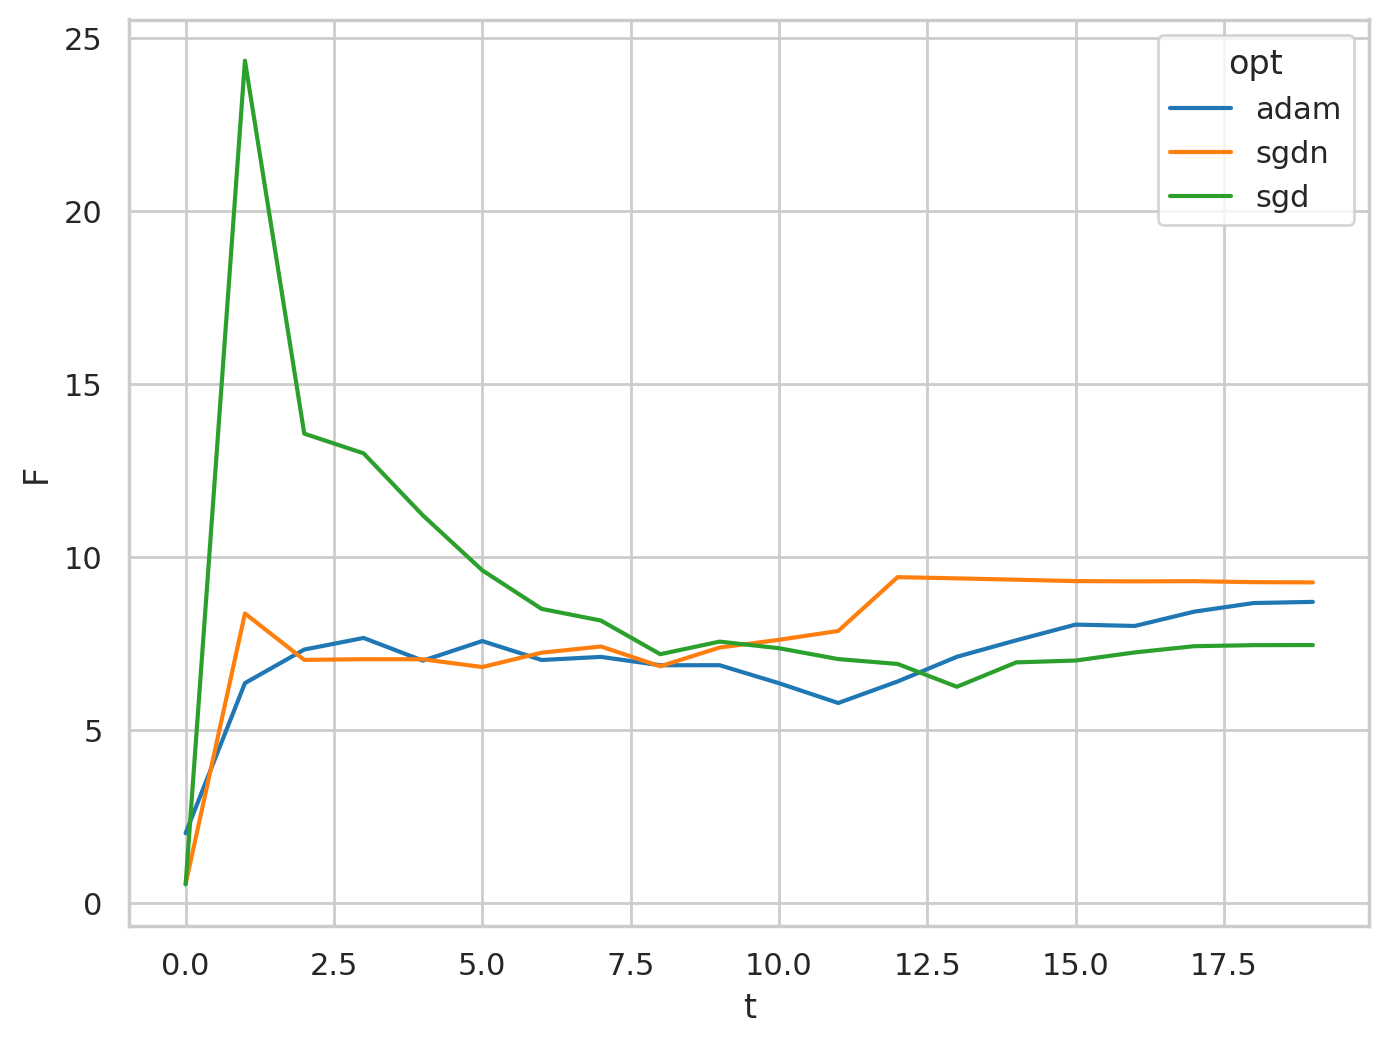

In [25]:
F = F_test(d_,
           avg,
           fixed="opt",
           key="yvh",
           distf=edist,
           dists=dists,
           verbose=False)
df = pd.DataFrame(F, columns=["opt", "F", "t", "sb", "sw"])
sns.lineplot(data=df, x="t", y="F", hue="opt")

<AxesSubplot:xlabel='t', ylabel='F'>

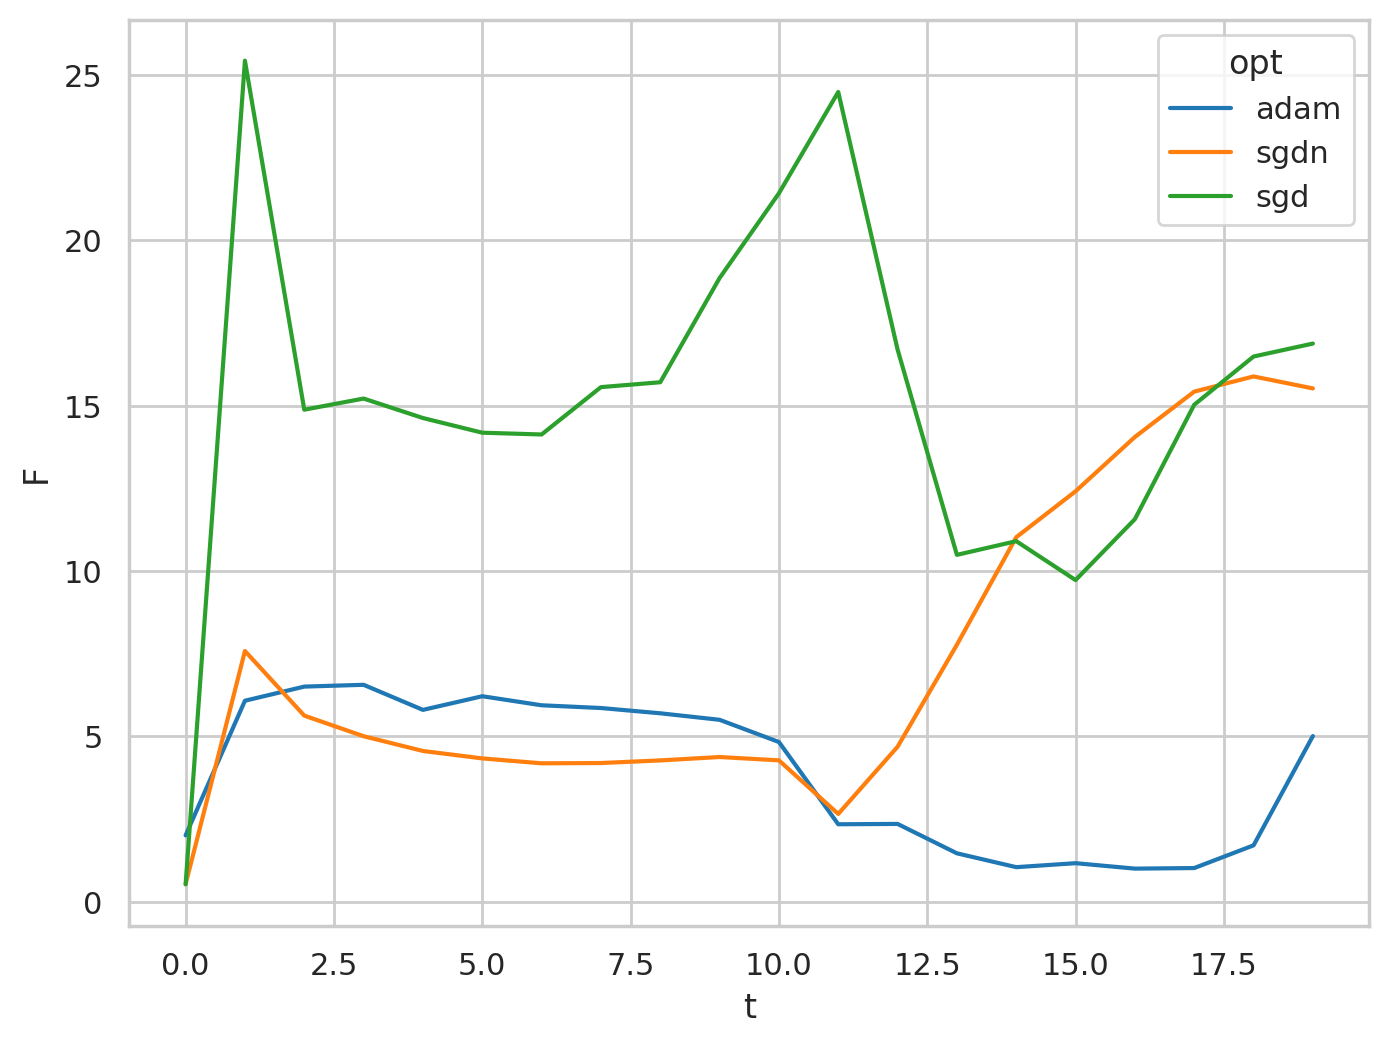

In [26]:
F = F_test(d_,
           avg,
           fixed="opt",
           key="yh",
           distf=edist,
           dists=dists,
           verbose=False)
df = pd.DataFrame(F, columns=["opt", "F", "t", "sb", "sw"])
sns.lineplot(data=df, x="t", y="F", hue="opt")

### Single sample prediction

In [15]:
from embed import *
from utils import *

In [53]:
loc = 'results/models/new'
d = load_d(loc, cond={'bs':200, 'aug':True, 'wd':0.0, 'bn':True}, avg_err=False, numpy=True, probs=False)

Index(['seed', 'm', 'opt', 'lr', 'wd', 'bn', 'aug', 'bs', 't', 'yh', 'f', 'e',
       'yvh', 'fv', 'ev'],
      dtype='object') 1800


In [80]:
idx = slice(0,-1,1)
avg_ent = []
for t in range(20):
    dt = d.iloc[get_idx(d, f"t=={t}")].reset_index()
    for (k, v) in dt.groupby(['m', 'opt']).indices.items():
        preds = np.stack(dt.iloc[v]['yh'].values)
        
        ent= (-preds*np.exp(preds)).sum(-1)[:, idx].mean(-1)
        if t == 19:
            err = np.stack(dt.iloc[v]['e'].values)[:, idx].mean()
            print(k, err)
        for (i, e) in enumerate(ent):
            avg_ent.append(dict(cond=k, ent=e, t=t))
df = pd.DataFrame(avg_ent)

('allcnn-96-144', 'adam') 0.0
('allcnn-96-144', 'sgd') 0.00067201344
('allcnn-96-144', 'sgdn') 0.0
('fc-1024-512-256-128', 'adam') 0.0
('fc-1024-512-256-128', 'sgd') 0.0
('fc-1024-512-256-128', 'sgdn') 0.0
('wr-4-8', 'adam') 0.0
('wr-4-8', 'sgd') 0.0063061262
('wr-4-8', 'sgdn') 0.0


<AxesSubplot:xlabel='t', ylabel='ent'>

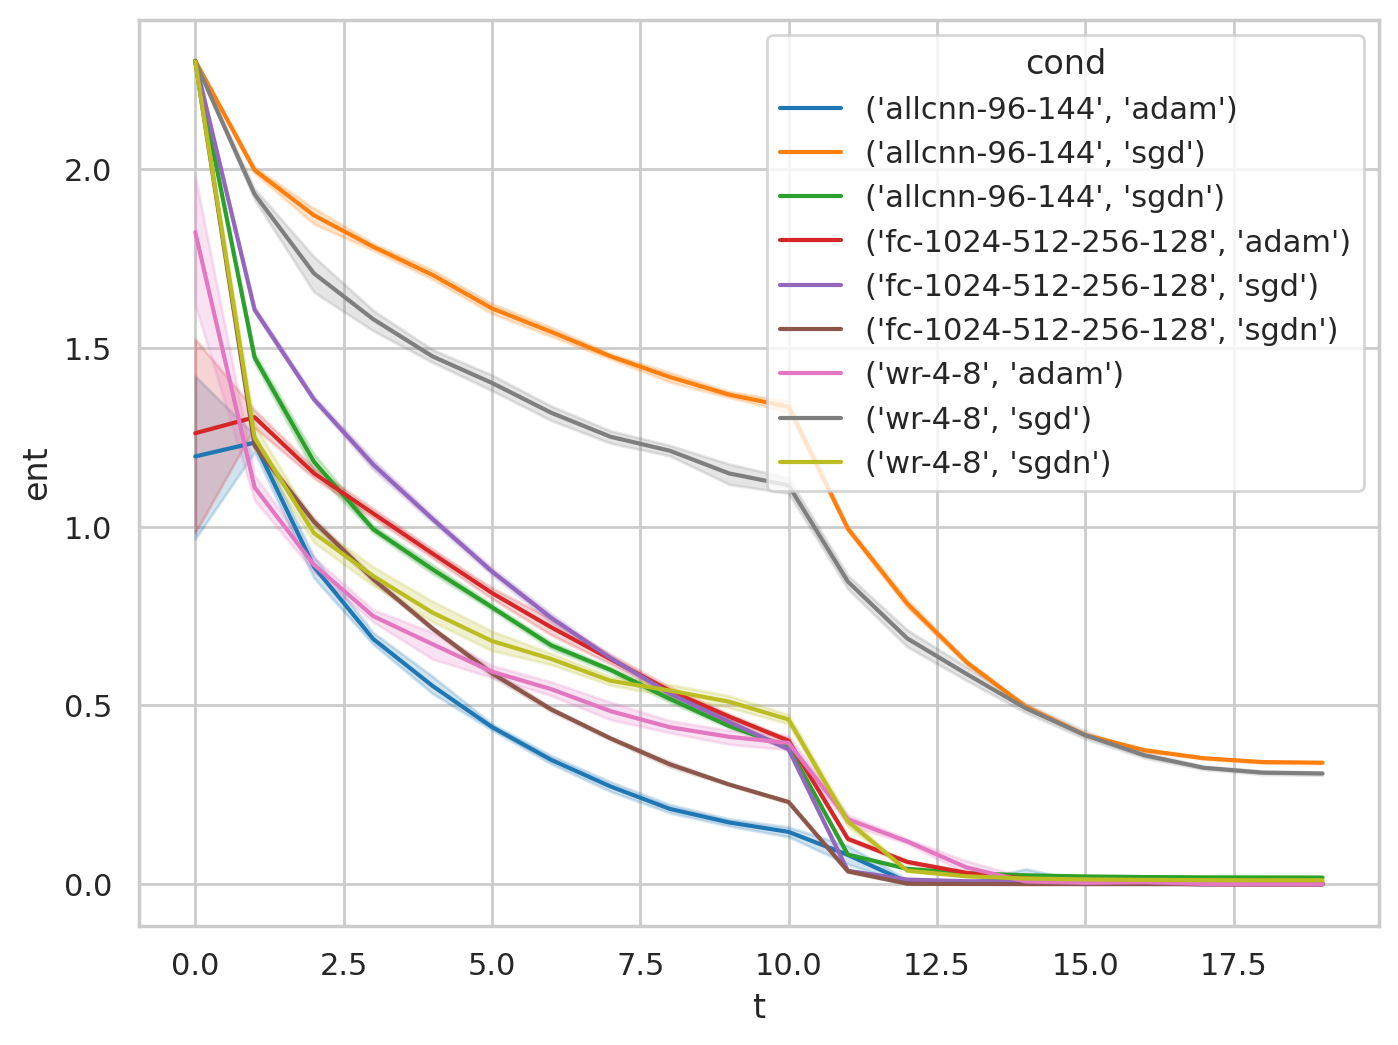

In [81]:
sns.lineplot(data=df, x='t', y='ent', hue='cond')

In [82]:
idx =  slice(0,-1,1)
avg_ent = []
for t in range(20):
    dt = d.iloc[get_idx(d, f"t=={t}")].reset_index()
    for (k, v) in dt.groupby(['m', 'opt']).indices.items():
        preds = np.stack(dt.iloc[v]['yvh'].values)
        
        ent= (-preds*np.exp(preds)).sum(-1)[:, idx].mean(-1)
        if t == 19:
            err = np.stack(dt.iloc[v]['ev'].values)[:, idx].mean()
            print(k, err)
        for (i, e) in enumerate(ent):
            avg_ent.append(dict(cond=k, ent=e, t=t))
df = pd.DataFrame(avg_ent)

('allcnn-96-144', 'adam') 0.20036003
('allcnn-96-144', 'sgd') 0.219972
('allcnn-96-144', 'sgdn') 0.20011002
('fc-1024-512-256-128', 'adam') 0.41516152
('fc-1024-512-256-128', 'sgd') 0.46061605
('fc-1024-512-256-128', 'sgdn') 0.4239524
('wr-4-8', 'adam') 0.18331833
('wr-4-8', 'sgd') 0.2519652
('wr-4-8', 'sgdn') 0.21233124


<AxesSubplot:xlabel='t', ylabel='ent'>

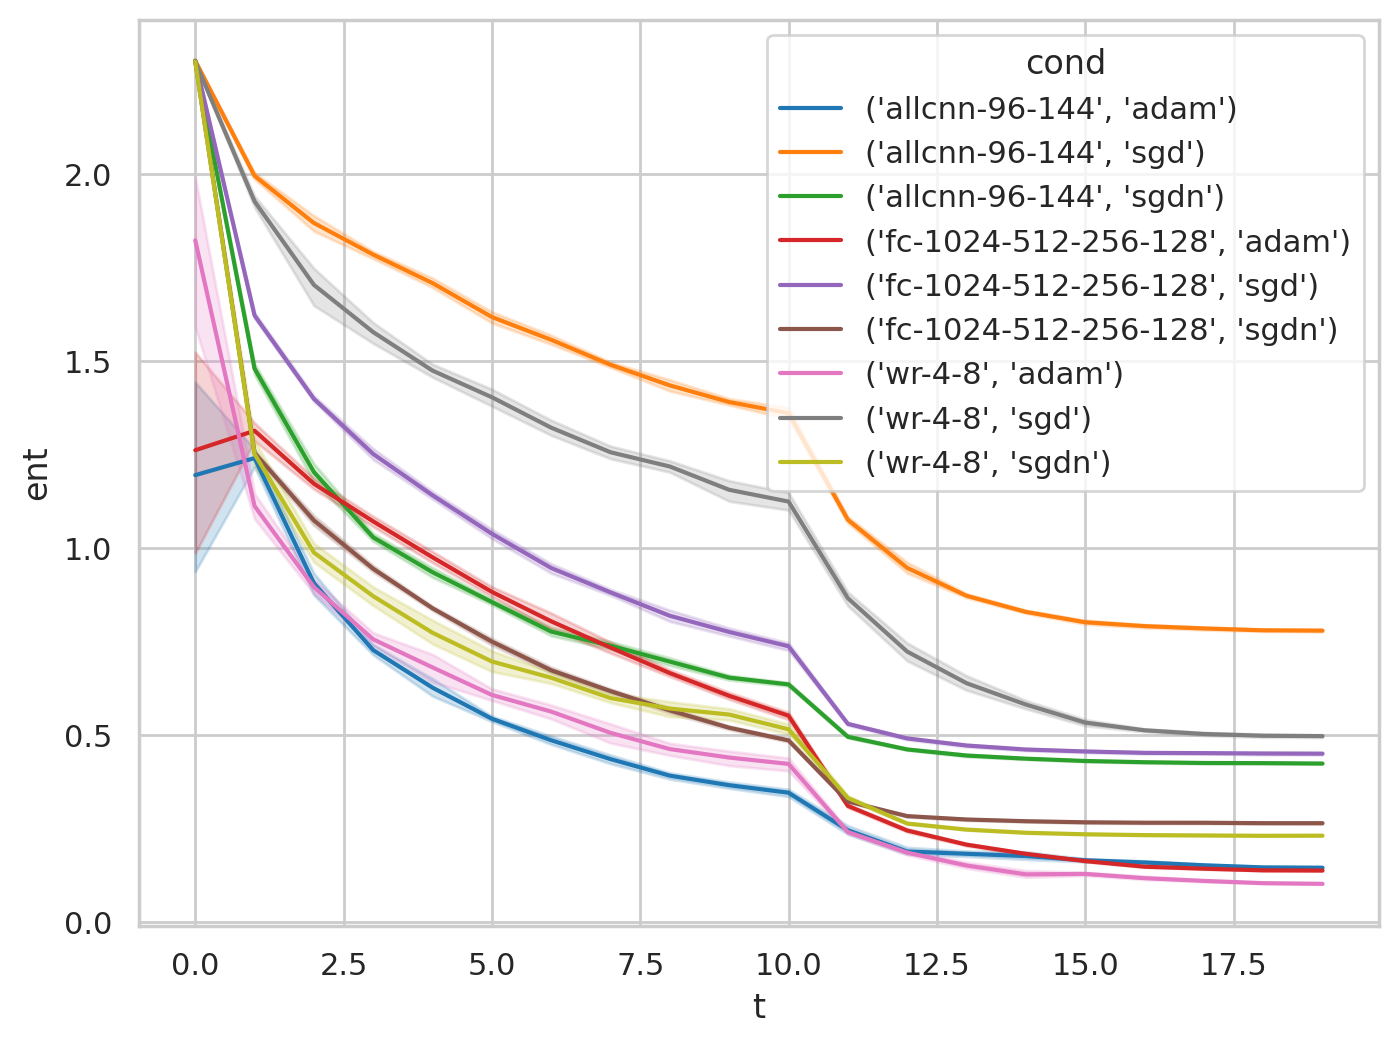

In [83]:
sns.lineplot(data=df, x='t', y='ent', hue='cond')